<div style="text-align: center;">
    <h1 style="color: purple; font-size: 60px; margin-bottom: 30px;">NFLAI</h1>
    <h3 style="color: black;">Created by Tyler Durette</h3>
    <!-- <p style="font-size: 20px; font-style: italic;">Analyzing team and player trends, betting performances, and more using AI.</p> -->
    <hr style="border: 2px solid purple; width: 55%;">
    <img src="https://media.bleacherreport.com/image/upload/c_crop,h_0.90,w_0.90,x_0.01,y_0.05/w_650/v1693966577/wy9rjhloyplkvjq7ljgz.jpg" alt="NFL AI Logo" width="800"/>
</div>

In [2]:
import sqlite3
from IPython.display import display
import pandas as pd
from tabulate import tabulate
import os
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings
# warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
# warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
!rm -rf data
!cp -r ../Scrapers/data .
!cp ../Scrapers/nfl.db data/

In [27]:
db_path = 'data/nfl.db'
conn = sqlite3.connect(db_path)
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()
for table in tables:
    table_name = table[0]
    # Read the table into a pandas DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    # Save the DataFrame to a CSV file
    csv_file_name = f"data/{table_name}.csv"
    df.to_csv(csv_file_name, index=False)
    print(f"Downloaded {table_name} to {csv_file_name}")
conn.close()

Downloaded Teams to data/Teams.csv
Downloaded Games to data/Games.csv
Downloaded PlayerStats to data/PlayerStats.csv
Downloaded Rosters to data/Rosters.csv


In [ ]:
# Cleaning 

file_path = 'data/all_passing_rushing_receiving.csv'  # Adjust this path as needed
df = pd.read_csv(file_path)
row_count_before = df.shape[0]
print(f"Row count before removing duplicates: {row_count_before}")
df_cleaned = df.drop_duplicates()
row_count_after = df_cleaned.shape[0]
print(f"Row count after removing duplicates: {row_count_after}")
df_cleaned.to_csv('data/all_passing_rushing_receiving.csv', index=False)
print("Cleaned file saved as 'all_passing_rushing_receiving.csv'")

In [1]:
# Downloading logos

import os
import requests

# Create a directory to store images
os.makedirs('images', exist_ok=True)

# List of URLs for team logos and their corresponding abbreviations
team_logos = {
    "https://cdn.fastassets.io/images/team-logos/New-Orleans-Saints.png": "NO",
    "https://cdn.fastassets.io/images/team-logos/Atlanta-Falcons.png": "ATL",
    "https://cdn.fastassets.io/images/team-logos/Pittsburgh-Steelers.png": "PIT",
    "https://cdn.fastassets.io/images/team-logos/Indianapolis-Colts.png": "IND",
    "https://cdn.fastassets.io/images/team-logos/Jacksonville-Jaguars.png": "JAX",
    "https://cdn.fastassets.io/images/team-logos/Houston-Texans.png": "HOU",
    "https://cdn.fastassets.io/images/team-logos/Minnesota-Vikings.png": "MIN",
    "https://cdn.fastassets.io/images/team-logos/Green-Bay-Packers.png": "GB",
    "https://cdn.fastassets.io/images/team-logos/Cincinnati-Bengals.png": "CIN",
    "https://cdn.fastassets.io/images/team-logos/Carolina-Panthers.png": "CAR",
    "https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/lar.png": "LAR",  # Corrected
    "https://cdn.fastassets.io/images/team-logos/Chicago-Bears.png": "CHI",
    "https://cdn.fastassets.io/images/team-logos/Denver-Broncos.png": "DEN",
    "https://cdn.fastassets.io/images/team-logos/Tampa-Bay-Buccaneers.png": "TB",
    "https://cdn.fastassets.io/images/team-logos/Seattle-Seahawks.png": "SEA",
    "https://cdn.fastassets.io/images/team-logos/San-Francisco-49ers.png": "SF",
    "https://cdn.fastassets.io/images/team-logos/Arizona-Cardinals.png": "ARI",
    "https://cdn.fastassets.io/images/team-logos/Dallas-Cowboys.png": "DAL",
    "https://cdn.fastassets.io/images/team-logos/Philadelphia-Eagles.png": "PHI",
    "https://cdn.fastassets.io/images/team-logos/Washington-Redskins.png": "WAS",  # Corrected
    "https://cdn.fastassets.io/images/team-logos/New-York-Giants.png": "NYG",
    "https://cdn.fastassets.io/images/team-logos/Kansas-City-Chiefs.png": "KC",
    "https://s.yimg.com/cv/apiv2/default/nfl/20200908/500x500/raiders_wbg.png": "LVR",  # Corrected
    "https://a.espncdn.com/combiner/i?img=/i/teamlogos/nfl/500/lac.png": "LAC",  # Corrected
    "https://cdn.fastassets.io/images/team-logos/Buffalo-Bills.png": "BUF",
    "https://cdn.fastassets.io/images/team-logos/Miami-Dolphins.png": "MIA",
    "https://cdn.fastassets.io/images/team-logos/New-York-Jets.png": "NYJ",
    "https://cdn.fastassets.io/images/team-logos/New-England-Patriots.png": "NE",
    "https://cdn.fastassets.io/images/team-logos/Cleveland-Browns.png": "CLE",
    "https://cdn.fastassets.io/images/team-logos/Baltimore-Ravens.png": "BAL",
    "https://cdn.fastassets.io/images/team-logos/Detroit-Lions.png": "DET",
    "https://cdn.fastassets.io/images/team-logos/Tennessee-Titans.png": "TEN"
}

# Download each logo and save it with the abbreviation as the file name
for url, abbreviation in team_logos.items():
    try:
        img_data = requests.get(url).content  # Download the image content
        with open(f'images/{abbreviation}.png', 'wb') as handler:
            handler.write(img_data)  # Save the image to the file
        print(f"Downloaded {abbreviation}.png")
    except Exception as e:
        print(f"Failed to download {abbreviation}: {e}")

print("All images have been downloaded.")



Downloaded NO.png
Downloaded ATL.png
Downloaded PIT.png
Downloaded IND.png
Downloaded JAX.png
Downloaded HOU.png
Downloaded MIN.png
Downloaded GB.png
Downloaded CIN.png
Downloaded CAR.png
Downloaded LAR.png
Downloaded CHI.png
Downloaded DEN.png
Downloaded TB.png
Downloaded SEA.png
Downloaded SF.png
Downloaded ARI.png
Downloaded DAL.png
Downloaded PHI.png
Downloaded WAS.png
Downloaded NYG.png
Downloaded KC.png
Downloaded LVR.png
Downloaded LAC.png
Downloaded BUF.png
Downloaded MIA.png
Downloaded NYJ.png
Downloaded NE.png
Downloaded CLE.png
Downloaded BAL.png
Downloaded DET.png
Downloaded TEN.png
All images have been downloaded.


In [2]:
# Downloading player headshots

import os
import pandas as pd
import requests

# Load the player_stats data from your file in the 'data/' directory
df_player_stats = pd.read_csv('data/player_stats.csv')

# Filter out QBs with valid headshot URLs and remove duplicates based on player_display_name
# unique_qbs_with_urls = df_player_stats[(df_player_stats['position'] == 'QB') & df_player_stats['headshot_url'].notna()] \
unique_qbs_with_urls = df_player_stats[df_player_stats['headshot_url'].notna()] \
                        .drop_duplicates(subset=['player_display_name'])

# Set up the directory to save images
image_folder = 'images'
os.makedirs(image_folder, exist_ok=True)

# Initialize a counter for downloaded images
downloaded_count = 0
total_qbs = len(unique_qbs_with_urls)

# Iterate through the unique QBs and download their headshots
for index, row in unique_qbs_with_urls.iterrows():
    player_name = row['player_display_name'].lower().replace(' ', '_')
    headshot_url = row['headshot_url']
    image_path = os.path.join(image_folder, f"{player_name}.png")
    
    # Download the image and save it
    try:
        response = requests.get(headshot_url)
        if response.status_code == 200:
            with open(image_path, 'wb') as file:
                file.write(response.content)
            downloaded_count += 1
            print(f"Downloaded {player_name}'s headshot ({downloaded_count}/{total_qbs}).")
        else:
            print(f"Failed to download {player_name}'s headshot (Status code: {response.status_code}).")
    except Exception as e:
        print(f"Error downloading {player_name}'s headshot: {e}")

# Print final result
print(f"Download complete: {downloaded_count}/{total_qbs} images successfully downloaded.")


Downloaded matt_hasselbeck's headshot (1/1628).
Downloaded steve_heiden's headshot (2/1628).
Downloaded peyton_manning's headshot (3/1628).
Downloaded michael_pittman's headshot (4/1628).
Downloaded bobby_brown's headshot (5/1628).
Downloaded tom_brady's headshot (6/1628).
Downloaded mike_vick's headshot (7/1628).
Downloaded steve_smith's headshot (8/1628).
Downloaded drew_brees's headshot (9/1628).
Downloaded cedrick_wilson's headshot (10/1628).
Downloaded josh_mccown's headshot (11/1628).
Downloaded antonio_gates's headshot (12/1628).
Downloaded anquan_boldin's headshot (13/1628).
Downloaded jason_witten's headshot (14/1628).
Downloaded carson_palmer's headshot (15/1628).
Downloaded malcom_floyd's headshot (16/1628).
Downloaded wes_welker's headshot (17/1628).
Downloaded steven_jackson's headshot (18/1628).
Downloaded matt_schaub's headshot (19/1628).
Downloaded eli_manning's headshot (20/1628).
Downloaded jerricho_cotchery's headshot (21/1628).
Downloaded luke_mccown's headshot (22/

# Table of Contents
- [BETTING TRENDS](#betting-trends)
  - [General](#betting-general)
  - [Performance as Favorite](#performance-as-favorite)
  - [Performance as Underdog](#performance-as-underdog)
- [TEAM TRENDS](#team-trends)
    - [General](#team-general)
    - [Defense](#defense)
    - [Sacks](#sacks)
    - [Offense](#offense)
        - [Passing](#passing)
        - [Rushing](#rushing)
- [PLAYER TRENDS](#player-trends)
    - [General](#player-general)
    - [Quarterbacks](#quarterbacks)
    - [Running Backs](#running-backs)
    - [Wide Receivers](#wide-receivers)
    - [Tight Ends](#tight-ends)
- [RANDOM](#random)

## BETTING TRENDS <a id="betting-trends"></a>

### General <a id="betting-general"></a>

In [43]:
# ATS records 2024 season

conn = sqlite3.connect('data/nfl.db')
cursor = conn.cursor()

query_all_games_with_spread = """
    SELECT * FROM Games
    WHERE season = 2024 AND game_type = 'REG' AND away_score IS NOT NULL AND home_score IS NOT NULL
"""

cursor.execute(query_all_games_with_spread)
all_games_spread = cursor.fetchall()

ats_records = {}

def update_ats_record(team, result):
    if team not in ats_records:
        ats_records[team] = {"ATS Wins": 0, "ATS Losses": 0, "ATS Pushes": 0}
    
    if result == "ATS Win":
        ats_records[team]["ATS Wins"] += 1
    elif result == "ATS Loss":
        ats_records[team]["ATS Losses"] += 1
    elif result == "ATS Push":
        ats_records[team]["ATS Pushes"] += 1

for game in all_games_spread:
    game_id, season, week, game_type, date, weekday, gametime, away_team, away_score, home_team, home_score, location, result, total, overtime, spread_line, total_line, *rest = game

    if spread_line is not None:
        if home_score - away_score > spread_line:
            update_ats_record(home_team, "ATS Win")
            update_ats_record(away_team, "ATS Loss")
        elif home_score - away_score < spread_line:
            update_ats_record(home_team, "ATS Loss")
            update_ats_record(away_team, "ATS Win")
        else:
            update_ats_record(home_team, "ATS Push")
            update_ats_record(away_team, "ATS Push")

ats_records_df = pd.DataFrame.from_dict(ats_records, orient='index')
ats_records_df['Total ATS Games'] = ats_records_df['ATS Wins'] + ats_records_df['ATS Losses'] + ats_records_df['ATS Pushes']
ats_records_df['Win Percentage'] = ats_records_df['ATS Wins'] / ats_records_df['Total ATS Games']
ats_records_df = ats_records_df.sort_values(by='Win Percentage', ascending=False)

ats_records_df.reset_index(inplace=True)
ats_records_df.rename(columns={'index': 'Team'}, inplace=True)
print(ats_records_df[['Team', 'ATS Wins', 'ATS Losses', 'ATS Pushes', 'Win Percentage']].head(32))

conn.close()


   Team  ATS Wins  ATS Losses  ATS Pushes  Win Percentage
0   PIT         3           0           0        1.000000
1   MIN         3           0           0        1.000000
2    KC         2           1           0        0.666667
3    NE         2           1           0        0.666667
4   DET         2           1           0        0.666667
5   WAS         2           1           0        0.666667
6    TB         2           1           0        0.666667
7   DEN         2           1           0        0.666667
8   LAC         2           1           0        0.666667
9   IND         2           1           0        0.666667
10   NO         2           1           0        0.666667
11  NYJ         2           1           0        0.666667
12  PHI         2           1           0        0.666667
13   GB         2           1           0        0.666667
14  ARI         2           1           0        0.666667
15  BUF         2           1           0        0.666667
16  NYG       

In [44]:
# ATS records 2023 season

conn = sqlite3.connect('data/nfl.db')
cursor = conn.cursor()

query_all_games_with_spread = """
    SELECT * FROM Games
    WHERE season = 2023 AND game_type = 'REG' AND away_score IS NOT NULL AND home_score IS NOT NULL
"""

cursor.execute(query_all_games_with_spread)
all_games_spread = cursor.fetchall()

ats_records = {}

def update_ats_record(team, result):
    if team not in ats_records:
        ats_records[team] = {"ATS Wins": 0, "ATS Losses": 0, "ATS Pushes": 0}
    
    if result == "ATS Win":
        ats_records[team]["ATS Wins"] += 1
    elif result == "ATS Loss":
        ats_records[team]["ATS Losses"] += 1
    elif result == "ATS Push":
        ats_records[team]["ATS Pushes"] += 1

for game in all_games_spread:
    game_id, season, week, game_type, date, weekday, gametime, away_team, away_score, home_team, home_score, location, result, total, overtime, spread_line, total_line, *rest = game

    if spread_line is not None:
        if home_score - away_score > spread_line:
            update_ats_record(home_team, "ATS Win")
            update_ats_record(away_team, "ATS Loss")
        elif home_score - away_score < spread_line:
            update_ats_record(home_team, "ATS Loss")
            update_ats_record(away_team, "ATS Win")
        else:
            update_ats_record(home_team, "ATS Push")
            update_ats_record(away_team, "ATS Push")

ats_records_df = pd.DataFrame.from_dict(ats_records, orient='index')
ats_records_df['Total ATS Games'] = ats_records_df['ATS Wins'] + ats_records_df['ATS Losses'] + ats_records_df['ATS Pushes']
ats_records_df['Win Percentage'] = ats_records_df['ATS Wins'] / ats_records_df['Total ATS Games']
ats_records_df = ats_records_df.sort_values(by='Win Percentage', ascending=False)

ats_records_df.reset_index(inplace=True)
ats_records_df.rename(columns={'index': 'Team'}, inplace=True)
print(ats_records_df[['Team', 'ATS Wins', 'ATS Losses', 'ATS Pushes', 'Win Percentage']].head(32))

conn.close()

   Team  ATS Wins  ATS Losses  ATS Pushes  Win Percentage
0   DET        12           5           0        0.705882
1    TB        11           6           0        0.647059
2   BAL        11           6           0        0.647059
3   DAL        10           7           0        0.588235
4   LAR        10           6           1        0.588235
5   PIT        10           7           0        0.588235
6   MIA        10           7           0        0.588235
7   LVR        10           5           2        0.588235
8    KC         9           7           1        0.529412
9   ARI         9           8           0        0.529412
10   SF         9           8           0        0.529412
11   GB         9           8           0        0.529412
12  JAX         9           8           0        0.529412
13  IND         9           8           0        0.529412
14  CLE         9           6           2        0.529412
15  HOU         9           8           0        0.529412
16  NYG       

In [35]:
# Teams ATS Records Loop & Save All Seasons

def ats_result(row, team):
    try:
        spread = float(row['home_spread']) if row['home_team'] == team else float(row['away_spread'])
        score_diff = row['home_score'] - row['away_score'] if row['home_team'] == team else row['away_score'] - row['home_score']
        if score_diff > spread:
            return 'Win'
        elif score_diff < spread:
            return 'Loss'
        else:
            return 'Push'
    except ValueError:
        return 'Invalid'

csv_path = 'data/Games.csv'  # Adjust the path to your CSV file
games_df = pd.read_csv(csv_path)

# Convert relevant columns to numeric, handling errors
games_df['home_spread'] = pd.to_numeric(games_df['home_spread'], errors='coerce')
games_df['away_spread'] = pd.to_numeric(games_df['away_spread'], errors='coerce')

# List of all NFL teams
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 
         'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 
         'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

# Create a list to collect the results for saving
results = []

# Loop through each season year available in the data
for season_year in games_df['season'].unique():
    for team in teams:
        relevant_columns = ['home_team', 'away_team', 'home_score', 'away_score', 'home_spread', 'away_spread', 'season']
        # Filter for the current season and team
        team_games = games_df[(games_df['home_team'] == team) | (games_df['away_team'] == team)]
        team_games = team_games[team_games['season'] == season_year]
        team_games = team_games[relevant_columns]
        
        # Calculate ATS result
        team_games['ATS_Result'] = team_games.apply(lambda row: ats_result(row, team), axis=1)

        overall_ats_record = team_games['ATS_Result'].value_counts().reset_index()
        overall_ats_record.columns = ['ATS_Result', 'Count']
        overall_ats_record['Location'] = 'Overall'
        overall_ats_record['Team'] = team
        overall_ats_record['Season'] = season_year

        home_ats_record = team_games[team_games['home_team'] == team]['ATS_Result'].value_counts().reset_index()
        home_ats_record.columns = ['ATS_Result', 'Count']
        home_ats_record['Location'] = 'Home'
        home_ats_record['Team'] = team
        home_ats_record['Season'] = season_year

        away_ats_record = team_games[team_games['away_team'] == team]['ATS_Result'].value_counts().reset_index()
        away_ats_record.columns = ['ATS_Result', 'Count']
        away_ats_record['Location'] = 'Away'
        away_ats_record['Team'] = team
        away_ats_record['Season'] = season_year

        # Append results to the list
        results.append(overall_ats_record)
        results.append(home_ats_record)
        results.append(away_ats_record)

# Combine all results into a single DataFrame
final_df = pd.concat(results)

# Save the results to a CSV file
output_csv_path = 'data/ATS_Records.csv'
final_df.to_csv(output_csv_path, index=False)

print(f"ATS records have been saved to {output_csv_path}")
!open data/ATS_Records.csv

ATS records have been saved to data/ATS_Records.csv


In [38]:
# Teams longest ATS winning & losing streaks (2023)

db_path = 'data/nfl.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Query to get all regular season (REG) games from the 2023 season where scores and spread information are available
query_reg_season_2023_games_with_spread = """
    SELECT * FROM Games
    WHERE season = 2023 AND game_type = 'REG' AND away_score IS NOT NULL AND home_score IS NOT NULL
"""

cursor.execute(query_reg_season_2023_games_with_spread)
reg_season_games_2023_spread = cursor.fetchall()

# Now, let's calculate ATS streaks as per the original plan
def calculate_ats_streaks():
    streak_data = {}

    for game in reg_season_games_2023_spread:
        game_id, season, week, game_type, date, weekday, gametime, away_team, away_score, home_team, home_score, location, result, total, overtime, spread_line, total_line, *rest = game
        
        margin_of_victory = home_score - away_score
        if spread_line is not None:
            # Determine ATS result for home and away teams
            home_result = "Win" if margin_of_victory > spread_line else "Loss" if margin_of_victory < spread_line else "Push"
            away_result = "Win" if -margin_of_victory > -spread_line else "Loss" if -margin_of_victory < -spread_line else "Push"

            if home_team not in streak_data:
                streak_data[home_team] = {"Longest Win Streak": 0, "Longest Loss Streak": 0, "Current Win Streak": 0, "Current Loss Streak": 0}
            if away_team not in streak_data:
                streak_data[away_team] = {"Longest Win Streak": 0, "Longest Loss Streak": 0, "Current Win Streak": 0, "Current Loss Streak": 0}
            
            # Update streaks for home team
            if home_result == "Win":
                streak_data[home_team]["Current Win Streak"] += 1
                streak_data[home_team]["Current Loss Streak"] = 0
                streak_data[home_team]["Longest Win Streak"] = max(streak_data[home_team]["Longest Win Streak"], streak_data[home_team]["Current Win Streak"])
            elif home_result == "Loss":
                streak_data[home_team]["Current Loss Streak"] += 1
                streak_data[home_team]["Current Win Streak"] = 0
                streak_data[home_team]["Longest Loss Streak"] = max(streak_data[home_team]["Longest Loss Streak"], streak_data[home_team]["Current Loss Streak"])

            # Update streaks for away team
            if away_result == "Win":
                streak_data[away_team]["Current Win Streak"] += 1
                streak_data[away_team]["Current Loss Streak"] = 0
                streak_data[away_team]["Longest Win Streak"] = max(streak_data[away_team]["Longest Win Streak"], streak_data[away_team]["Current Win Streak"])
            elif away_result == "Loss":
                streak_data[away_team]["Current Loss Streak"] += 1
                streak_data[away_team]["Current Win Streak"] = 0
                streak_data[away_team]["Longest Loss Streak"] = max(streak_data[away_team]["Longest Loss Streak"], streak_data[away_team]["Current Loss Streak"])

    return streak_data

# Calculate the ATS streaks
ats_streaks = calculate_ats_streaks()

# Convert the streak data into a DataFrame for display
ats_streaks_df = pd.DataFrame.from_dict(ats_streaks, orient='index')
ats_streaks_df.reset_index(inplace=True)
ats_streaks_df.rename(columns={'index': 'Team'}, inplace=True)
display(ats_streaks_df)

# Display the ATS streaks data
# import ace_tools as tools; tools.display_dataframe_to_user(name="ATS Streaks for 2023 Regular Season", dataframe=ats_streaks_df)

,Team,Longest Win Streak,Longest Loss Streak,Current Win Streak,Current Loss Streak
0,KC,3,3,2,0
1,DET,4,2,4,0
2,ATL,2,5,0,2
3,CAR,2,5,0,2
4,BAL,3,1,0,1
5,HOU,4,2,2,0
6,CLE,3,2,0,1
7,CIN,4,3,1,0
8,IND,4,3,0,3
9,JAX,5,4,0,1


In [39]:
# Teams covering spread 3 games in a row (2023)
# https://www.statmuse.com/nfl/ask/cowboys-ats-record-2023

db_path = 'data/nfl.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Re-query regular season games from the 2023 season
query_reg_season_2023_games_with_spread = """
    SELECT * FROM Games
    WHERE season = 2023 AND game_type = 'REG' AND away_score IS NOT NULL AND home_score IS NOT NULL
"""

cursor.execute(query_reg_season_2023_games_with_spread)
reg_season_games_2023_spread = cursor.fetchall()

# Function to find all instances where a team covered the spread 3 times in a row
def find_three_game_streaks():
    three_game_streaks = []
    streak_data = {}

    # Loop through the games to track ATS wins per team
    for game in reg_season_games_2023_spread:
        game_id, season, week, game_type, date, weekday, gametime, away_team, away_score, home_team, home_score, location, result, total, overtime, spread_line, total_line, *rest = game

        margin_of_victory = home_score - away_score
        if spread_line is not None:
            # Determine ATS result for home and away teams
            home_result = "Win" if margin_of_victory > spread_line else "Loss" if margin_of_victory < spread_line else "Push"
            away_result = "Win" if -margin_of_victory > -spread_line else "Loss" if -margin_of_victory < -spread_line else "Push"
            
            if home_team not in streak_data:
                streak_data[home_team] = {"current_streak": [], "streaks": []}
            if away_team not in streak_data:
                streak_data[away_team] = {"current_streak": [], "streaks": []}

            # Track streak for home team
            if home_result == "Win":
                streak_data[home_team]["current_streak"].append(int(week))
                if len(streak_data[home_team]["current_streak"]) == 3:
                    streak_data[home_team]["streaks"].append(streak_data[home_team]["current_streak"][:])
                    streak_data[home_team]["current_streak"] = []
            else:
                streak_data[home_team]["current_streak"] = []

            # Track streak for away team
            if away_result == "Win":
                streak_data[away_team]["current_streak"].append(int(week))
                if len(streak_data[away_team]["current_streak"]) == 3:
                    streak_data[away_team]["streaks"].append(streak_data[away_team]["current_streak"][:])
                    streak_data[away_team]["current_streak"] = []
            else:
                streak_data[away_team]["current_streak"] = []

    # Gather all teams that had 3-game ATS streaks
    for team, streak_info in streak_data.items():
        for streak in streak_info["streaks"]:
            three_game_streaks.append({
                "Team": team,
                "Streak Weeks": streak
            })

    return three_game_streaks

# Find all the three-game ATS win streaks
three_game_streaks = find_three_game_streaks()

# List the instances of teams covering the spread 3 times in a row
three_game_streaks_list = []
for idx, streak in enumerate(three_game_streaks, 1):
    streak_string = f"{idx}. {streak['Team']} {', '.join(map(str, streak['Streak Weeks']))}"
    three_game_streaks_list.append(streak_string)

# Display the list of streaks
three_game_streaks_list

['1. KC 5, 6, 7',
 '2. DET 3, 4, 5',
 '3. DET 15, 16, 17',
 '4. BAL 15, 16, 17',
 '5. HOU 3, 4, 5',
 '6. CLE 9, 10, 11',
 '7. CIN 5, 6, 8',
 '8. IND 9, 10, 12',
 '9. JAX 4, 5, 6',
 '10. MIN 6, 7, 8',
 '11. MIN 9, 10, 11',
 '12. TB 8, 9, 10',
 '13. TB 14, 15, 16',
 '14. PIT 16, 17, 18',
 '15. SF 3, 4, 5',
 '16. ARI 1, 2, 3',
 '17. CHI 11, 12, 14',
 '18. GB 1, 2, 3',
 '19. GB 11, 12, 13',
 '20. DEN 7, 8, 10',
 '21. LVR 9, 10, 11',
 '22. LVR 15, 16, 17',
 '23. MIA 1, 2, 3',
 '24. PHI 9, 11, 12',
 '25. SEA 2, 3, 4',
 '26. SEA 13, 14, 15',
 '27. LAR 12, 13, 14',
 '28. NYG 11, 12, 14',
 '29. NYG 16, 17, 18',
 '30. DAL 10, 11, 12',
 '31. NYJ 4, 5, 6',
 '32. BUF 2, 3, 4']

In [47]:
# Teams losing spread 3 games in a row (2023)
# https://www.statmuse.com/nfl/ask/cowboys-ats-record-2023

db_path = 'data/nfl.db'
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Re-query regular season games from the 2023 season
query_reg_season_2023_games_with_spread = """
    SELECT * FROM Games
    WHERE season = 2023 AND game_type = 'REG' AND away_score IS NOT NULL AND home_score IS NOT NULL
"""

cursor.execute(query_reg_season_2023_games_with_spread)
reg_season_games_2023_spread = cursor.fetchall()

# Function to find all instances where a team lost against the spread 3 times in a row
def find_three_game_losing_streaks():
    three_game_losing_streaks = []
    losing_streak_data = {}

    # Loop through the games to track ATS losses per team
    for game in reg_season_games_2023_spread:
        game_id, season, week, game_type, date, weekday, gametime, away_team, away_score, home_team, home_score, location, result, total, overtime, spread_line, total_line, *rest = game

        margin_of_victory = home_score - away_score
        if spread_line is not None:
            # Determine ATS result for home and away teams
            home_result = "Win" if margin_of_victory > spread_line else "Loss" if margin_of_victory < spread_line else "Push"
            away_result = "Win" if -margin_of_victory > -spread_line else "Loss" if -margin_of_victory < -spread_line else "Push"
            
            if home_team not in losing_streak_data:
                losing_streak_data[home_team] = {"current_losing_streak": [], "losing_streaks": []}
            if away_team not in losing_streak_data:
                losing_streak_data[away_team] = {"current_losing_streak": [], "losing_streaks": []}

            # Track losing streak for home team
            if home_result == "Loss":
                losing_streak_data[home_team]["current_losing_streak"].append(int(week))
                if len(losing_streak_data[home_team]["current_losing_streak"]) == 3:
                    losing_streak_data[home_team]["losing_streaks"].append(losing_streak_data[home_team]["current_losing_streak"][:])
                    losing_streak_data[home_team]["current_losing_streak"] = []
            else:
                losing_streak_data[home_team]["current_losing_streak"] = []

            # Track losing streak for away team
            if away_result == "Loss":
                losing_streak_data[away_team]["current_losing_streak"].append(int(week))
                if len(losing_streak_data[away_team]["current_losing_streak"]) == 3:
                    losing_streak_data[away_team]["losing_streaks"].append(losing_streak_data[away_team]["current_losing_streak"][:])
                    losing_streak_data[away_team]["current_losing_streak"] = []
            else:
                losing_streak_data[away_team]["current_losing_streak"] = []

    # Gather all teams that had 3-game ATS losing streaks
    for team, streak_info in losing_streak_data.items():
        for streak in streak_info["losing_streaks"]:
            three_game_losing_streaks.append({
                "Team": team,
                "Losing Streak Weeks": streak
            })

    return three_game_losing_streaks

# Find all the three-game ATS losing streaks
three_game_losing_streaks = find_three_game_losing_streaks()

# List the instances of teams losing the spread 3 times in a row
three_game_losing_streaks_list = []
for idx, streak in enumerate(three_game_losing_streaks, 1):
    streak_string = f"{idx}. {streak['Team']} {', '.join(map(str, streak['Losing Streak Weeks']))}"
    three_game_losing_streaks_list.append(streak_string)

# Display the list of losing streaks
three_game_losing_streaks_list

['1. ATL 2, 3, 4',
 '2. ATL 8, 9, 10',
 '3. CAR 3, 4, 5',
 '4. CIN 10, 11, 12',
 '5. IND 16, 17, 18',
 '6. JAX 13, 14, 15',
 '7. MIN 16, 17, 18',
 '8. NO 9, 10, 12',
 '9. TEN 9, 10, 11',
 '10. PIT 13, 14, 15',
 '11. SF 6, 7, 8',
 '12. WAS 11, 12, 13',
 '13. ARI 4, 5, 6',
 '14. CHI 1, 2, 3',
 '15. GB 4, 5, 7',
 '16. GB 14, 15, 16',
 '17. DEN 1, 2, 3',
 '18. LAC 10, 11, 12',
 '19. NE 4, 5, 6',
 '20. NE 8, 9, 10',
 '21. PHI 13, 14, 15',
 '22. PHI 16, 17, 18',
 '23. LAR 7, 8, 9',
 '24. NYG 1, 2, 3',
 '25. DAL 15, 16, 17',
 '26. NYJ 9, 10, 11',
 '27. NYJ 15, 16, 17',
 '28. BUF 5, 6, 7',
 '29. BUF 8, 9, 10']

In [70]:
# Print all 2023 games and ATS loss or win with differentials 
# https://www.statmuse.com/nfl/ask/cowboys-ats-record-2023

team_input = 'DAL'

GREEN = "\033[92m"
RED = "\033[91m"
RESET = "\033[0m"

def get_team_schedule_ats(team_name):
    db_path = 'data/nfl.db'  # Update with your local path if necessary
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Function to fetch and print results for a given season
    def fetch_and_print_season(season):
        # Query to get all regular season games for the given team in the specified season, sorted by week
        query = f"""
            SELECT * FROM Games
            WHERE season = {season} AND game_type = 'REG' 
            AND (home_team = ? OR away_team = ?) 
            AND home_score IS NOT NULL AND away_score IS NOT NULL
            ORDER BY week ASC
        """
        cursor.execute(query, (team_name, team_name))
        team_games = cursor.fetchall()

        print(f"{team_name} {season} Schedule:")
        for idx, game in enumerate(team_games, 1):
            game_id, season, week, game_type, date, weekday, gametime, away_team, away_score, home_team, home_score, location, result, total, overtime, spread_line, total_line, *rest = game
            
            # Determine whether the team is home or away
            if home_team == team_name:
                opponent = away_team
                margin_of_victory = home_score - away_score
                ats_diff = margin_of_victory - spread_line  # Calculate ATS differential for home team
                team_spread = -spread_line  # Use the actual spread for the home team
                team_result = "ATS win" if margin_of_victory > spread_line else "ATS loss" if margin_of_victory < spread_line else "Push"
            else:
                opponent = home_team
                margin_of_victory = away_score - home_score
                ats_diff = margin_of_victory + spread_line  # Calculate ATS differential for away team
                team_spread = spread_line  # Use the spread for the away team
                team_result = "ATS win" if margin_of_victory > -spread_line else "ATS loss" if margin_of_victory < -spread_line else "Push"
            
            result_color = GREEN if "win" in team_result else RED if "loss" in team_result else RESET
            ats_result_colored = f"{result_color}{team_result} {ats_diff:+.1f}{RESET}"

            print(f"{idx}. {team_spread} {opponent} - {ats_result_colored}")
        print()  # Blank line after each season's schedule

    fetch_and_print_season(2024)
    fetch_and_print_season(2023)
    fetch_and_print_season(2022)

get_team_schedule_ats(team_input)

DAL 2024 Schedule:
1. 2.5 CLE - ATS win +18.5
2. -6.5 NO - ATS loss -31.5
3. 1.5 BAL - ATS loss -1.5
4. -5.5 NYG - ATS loss -0.5

DAL 2023 Schedule:
1. -3.5 NYG - ATS win +36.5
2. -8.5 NYJ - ATS win +11.5
3. -11.5 ARI - ATS loss -23.5
4. -6.5 NE - ATS win +28.5
5. 3.5 SF - ATS loss -28.5
6. -1.5 LAC - ATS win +1.5
7. -6.5 LAR - ATS win +16.5
8. 3.5 PHI - ATS loss -1.5
9. -17.5 NYG - ATS win +14.5
10. -11.0 CAR - ATS win +12.0
11. -13.0 WAS - ATS win +22.0
12. -9.5 SEA - ATS loss -3.5
13. -3.5 PHI - ATS win +16.5
14. 2.0 BUF - ATS loss -19.0
15. 1.5 MIA - ATS loss -0.5
16. -5.5 DET - ATS loss -4.5
17. -13.0 WAS - ATS win +15.0

DAL 2022 Schedule:
1. 2.5 TB - ATS loss -13.5
2. 7.5 CIN - ATS win +10.5
3. 1.0 NYG - ATS win +8.0
4. -3.0 WAS - ATS win +12.0
5. 5.5 LAR - ATS win +17.5
6. 6.5 PHI - ATS loss -2.5
7. -7.0 DET - ATS win +11.0
8. -10.5 CHI - ATS win +9.5
9. -3.5 GB - ATS loss -6.5
10. -1.5 MIN - ATS win +35.5
11. -10.5 NYG - ATS loss -2.5
12. -11.0 IND - ATS win +24.0
13. -17.0 HO

In [ ]:
# Head-to-Head ATS Trends



In [37]:
# Last 10 games a team was between a +0.5 and +2 spread underdog

team = 'IND'
db_path = "data/nfl.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Query to get the last 20 games where the given team was underdogs between +0.5 and +2 points
query = f"""
SELECT game_id, season, week, date, home_team, home_score, away_team, away_score, home_spread, away_spread, total_line
FROM Games
WHERE ((home_team = '{team}' AND CAST(home_spread AS REAL) >= 0.5 AND CAST(home_spread AS REAL) <= 2) OR
       (away_team = '{team}' AND CAST(away_spread AS REAL) >= 0.5 AND CAST(away_spread AS REAL) <= 2))
ORDER BY date DESC
LIMIT 10;
"""
cursor.execute(query)
games = cursor.fetchall()
conn.close()

print("="*50)
print(f"Last 10 {team} Games as +0.5 to +2 Point Underdogs")
print("="*50)
for idx, game in enumerate(games, 1):
    game_id, season, week, date, home_team, home_score, away_team, away_score, home_spread, away_spread, total_line = game
    # Determine which spread applies to the team
    spread_line = float(home_spread) if home_team == team else float(away_spread)
    # Format the output exactly as requested
    print(f"{idx}. {date.split(' ')[0]} - {team} {home_score if home_team == team else away_score}.0 "
          f"vs {away_team if home_team == team else home_team} {away_score if home_team == team else home_score}.0 "
          f"(Spread: {spread_line}, O/U: {total_line})")

win_count = 0
cover_count = 0
point_differentials = []
points_scored = []
points_allowed = []
market_accuracy = []

# Process the game data and calculate metrics
for game in games:
    game_id, season, week, date, home_team, home_score, away_team, away_score, home_spread, away_spread, total_line = game
    
    # Determine which spread applies to the team
    spread_line = float(home_spread) if home_team == team else float(away_spread)
    total_line = float(total_line)
    colts_score = home_score if home_team == team else away_score
    opponent_score = away_score if home_team == team else home_score
    
    # Win/Loss determination
    if colts_score > opponent_score:
        win_count += 1
    
    # Spread cover determination
    if (colts_score + spread_line) >= opponent_score:
        cover_count += 1
    
    # Point differential
    point_differentials.append(colts_score - opponent_score)
    
    # Points scored and allowed
    points_scored.append(colts_score)
    points_allowed.append(opponent_score)
    
    # Market accuracy (difference between total points and O/U line)
    total_points = colts_score + opponent_score
    market_accuracy.append(total_points - total_line)

total_games = len(games)
win_rate = (win_count / total_games) * 100 if total_games > 0 else 0
cover_rate = (cover_count / total_games) * 100 if total_games > 0 else 0
avg_point_diff = np.mean(point_differentials) if total_games > 0 else 0
avg_points_scored = np.mean(points_scored) if total_games > 0 else 0
avg_points_allowed = np.mean(points_allowed) if total_games > 0 else 0
market_accuracy_avg = np.mean(market_accuracy) if total_games > 0 else 0
print("\n" + "="*50)
print(f"Analysis of {team} as +0.5 to +2 Point Underdogs")
print("="*50)
print(f"Total Games Analyzed: {total_games}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Cover Rate: {cover_rate:.2f}%")
print(f"Average Point Differential: {avg_point_diff:.2f}")
print(f"Average Points Scored: {avg_points_scored:.2f}")
print(f"Average Points Allowed: {avg_points_allowed:.2f}")
print(f"Market Accuracy (O/U): {market_accuracy_avg:.2f}")
print("="*50)

Last 20 IND Games as +0.5 to +2 Point Underdogs
1. 2024-01-06 - IND 19.0.0 vs HOU 23.0.0 (Spread: 1.5, O/U: 47.5)
2. 2023-10-29 - IND 27.0.0 vs NO 38.0.0 (Spread: 2.0, O/U: 43.5)
3. 2023-10-01 - IND 23.0.0 vs LAR 29.0.0 (Spread: 1.0, O/U: 44.5)
4. 2021-12-18 - IND 27.0.0 vs NE 17.0.0 (Spread: 1.0, O/U: 46.0)
5. 2020-10-11 - IND 23.0.0 vs CLE 32.0.0 (Spread: 1.0, O/U: 48.5)
6. 2019-12-01 - IND 17.0.0 vs TEN 31.0.0 (Spread: 1.0, O/U: 41.5)
7. 2019-11-03 - IND 24.0.0 vs PIT 26.0.0 (Spread: 1.0, O/U: 39.5)
8. 2019-01-05 - IND 21.0.0 vs HOU 7.0.0 (Spread: 2.0, O/U: 48.5)
9. 2018-09-30 - IND 34.0.0 vs HOU 37.0.0 (Spread: 1.0, O/U: 48.0)
10. 2018-09-09 - IND 23.0.0 vs CIN 34.0.0 (Spread: 1.0, O/U: 47.5)

Analysis of IND as +0.5 to +2 Point Underdogs
Total Games Analyzed: 10
Win Rate: 20.00%
Cover Rate: 20.00%
Average Point Differential: -3.60
Average Points Scored: 23.80
Average Points Allowed: 27.40
Market Accuracy (O/U): 5.70


In [ ]:
# Last 10 games when a team was greater than a -10 point favorite



In [ ]:
# # Betting Line Analysis

# df = pd.read_csv('Games.csv')

# # Filter for the specific seasons (e.g., last 5 seasons: 2019, 2020, 2021, 2022, 2023)
# df_recent = df[df['season'].isin([2019, 2020, 2021, 2022, 2023])].copy()

# # 1. Spread Line Performance: Calculate the difference between the actual game margin and the spread.
# df_recent.loc[:, 'game_margin'] = df_recent['home_score'] - df_recent['away_score']
# df_recent.loc[:, 'spread_performance'] = df_recent['game_margin'] - df_recent['spread_line']

# # Analyze which teams consistently beat or fall short of the spread
# spread_performance_summary = df_recent.groupby('home_team')['spread_performance'].mean().sort_values(ascending=False)

# # 2. Home vs. Away Performance: Calculate the performance difference at home versus away
# home_performance = df_recent.groupby('home_team')['spread_performance'].mean()
# away_performance = df_recent.groupby('away_team')['spread_performance'].mean()
# home_vs_away_performance = (home_performance - away_performance).sort_values(ascending=False)

# # 3. Over/Under Analysis: Calculate the difference between total points and total_line
# df_recent.loc[:, 'total_points'] = df_recent['home_score'] + df_recent['away_score']
# df_recent.loc[:, 'over_under_performance'] = df_recent['total_points'] - df_recent['total_line']

# # Analyze how often games go over or under the projected total points
# over_under_summary = df_recent.groupby('home_team')['over_under_performance'].mean().sort_values(ascending=False)

# # Display the summaries
# print("Spread Line Performance Summary (2019-2023):")
# print(spread_performance_summary)

# print("\nHome vs Away Performance Summary (2019-2023):")
# print(home_vs_away_performance)

# print("\nOver/Under Performance Summary (2019-2023):")
# print(over_under_summary)


### Performance as Favorite <a id="performance-as-favorite"></a>

### Performance as Underdog <a id="performance-as-underdog"></a>

In [16]:
# Loop all teams and saving to files ^

# Function to get underdog games
def get_underdog_games(team_name, seasons, db_path):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    
    # Prepare a query to get all games for the given team where they were the underdog
    query = f"""
    SELECT season, week, away_team, home_team, spread_line, team_favorite, result, home_score, away_score 
    FROM Games
    WHERE season IN ({','.join(map(str, seasons))})
    AND (home_team = '{team_name}' OR away_team = '{team_name}')
    AND team_favorite != '{team_name}';
    """
    
    # Execute query
    games = conn.execute(query).fetchall()
    conn.close()
    
    # Create a DataFrame
    columns = ['season', 'week', 'away_team', 'home_team', 'spread_line', 'team_favorite', 'result', 'home_score', 'away_score']
    games_df = pd.DataFrame(games, columns=columns)
    
    # Calculate the point differential and whether the team covered the spread
    games_df['point_differential'] = games_df.apply(lambda row: row['away_score'] - row['home_score'] if row['away_team'] == team_name else row['home_score'] - row['away_score'], axis=1)
    games_df['ats_differential'] = games_df.apply(lambda row: (row['point_differential'] + float(row['spread_line'])) if row['team_favorite'] != team_name else (row['point_differential'] - float(row['spread_line'])), axis=1)
    games_df['spread_covered'] = games_df['ats_differential'] > 0
    
    return games_df

# Function to summarize ATS record and return data for CSV
def summarize_ats_record_for_csv(team_name, seasons, db_path):
    underdog_games_df = get_underdog_games(team_name, seasons, db_path)
    
    results = []
    
    for _, game in underdog_games_df.iterrows():
        # Construct the result as a dictionary for later CSV storage
        result = {
            'season': game['season'],
            'week': game['week'],
            'team': team_name,
            'opponent': game['home_team'] if game['away_team'] == team_name else game['away_team'],
            'team_score': game['away_score'] if game['away_team'] == team_name else game['home_score'],
            'opponent_score': game['home_score'] if game['away_team'] == team_name else game['away_score'],
            'spread': game['spread_line'],
            'team_favorite': game['team_favorite'],
            'ats_result': 'WIN' if game['spread_covered'] else 'LOSE',
            'ats_differential': game['ats_differential'],
            'straight_up_result': 'WIN' if game['point_differential'] > 0 else 'LOSE'
        }
        results.append(result)
    
    return results

# Function to save the results for all teams into a CSV
def save_all_teams_to_csv(teams, seasons, db_path, csv_file_path):
    all_results = []
    for team in teams:
        team_results = summarize_ats_record_for_csv(team, seasons, db_path)
        all_results.extend(team_results)  # Accumulate the results for all teams
    
    # Convert the list of results to a DataFrame
    df = pd.DataFrame(all_results)
    
    # Save DataFrame to CSV
    df.to_csv(csv_file_path, index=False)
    print(f"All teams seasons data saved to {csv_file_path}\n\n")

# Example usage
db_path = 'data/nfl.db'  # Update this with the correct path to your database file
teams = [
    'ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE',
    'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC',
    'LV', 'LAC', 'LAR', 'MIA', 'MIN', 'NE', 'NO', 'NYG',
    'NYJ', 'PHI', 'PIT', 'SF', 'SEA', 'TB', 'TEN', 'WAS'
]  # List of all NFL teams
seasons = [2021, 2022, 2023]  # Specify the seasons you want to analyze
csv_file_path = 'nfl_game_summaries.csv'  # Path to save the CSV file

# Save the results to a CSV
save_all_teams_to_csv(teams, seasons, db_path, csv_file_path)

# Load the CSV file
df = pd.read_csv('nfl_game_summaries.csv')

# Set the team name directly
team_name = "DAL"  # Replace with the desired team name
# team_name = "BAL"  # Replace with the desired team name
print(f'------------------------------------------ {team_name} Underdog Results 2021-2023 ------------------------------------------')

# Filter the data for the given team
team_data = df[df['team'] == team_name].sort_values(by=['season', 'week'])

# Variables to store win/loss counts
ats_wins, ats_losses = 0, 0
straight_up_wins, straight_up_losses = 0, 0

current_season = None
for _, row in team_data.iterrows():
    # Check if the season has changed to print it
    if row['season'] != current_season:
        if current_season is not None:
            print()  # Print a newline before starting a new season
        current_season = row['season']
        print(f"{row['season']}:")

    # Determine if the team is home or away and format the spread
    home_or_away = "vs" if row['team_favorite'] == team_name else "@"
    spread_info = f"{abs(row['spread'])}" if row['spread'] > 0 else f"{abs(row['spread'])} ({row['team_favorite']} favored)"
    
    # Format the game result
    result = f"Week {str(row['week']).zfill(2)}: {row['team']} {home_or_away} {row['opponent']}, spread: {spread_info}, "
    score_result = f"result: {row['team']} {row['straight_up_result'].upper()} {row['team_score']}-{row['opponent_score']}, "
    straight_up = f"STRAIGHT-UP: {row['straight_up_result'].upper()}"
    ats = f"ATS: {row['ats_result'].upper()}, ATS Diff: {row['ats_differential']:+.1f}"

    # Print the formatted result
    print(f"{result}{score_result}{straight_up}, {ats}")

    # Count wins and losses
    if row['ats_result'].lower() == 'win':
        ats_wins += 1
    else:
        ats_losses += 1

    if row['straight_up_result'].lower() == 'win':
        straight_up_wins += 1
    else:
        straight_up_losses += 1

# Print final ATS and straight-up records
print()
print(f"\033[1mATS Record: {ats_wins}-{ats_losses}\033[0m")
print(f"\033[1mStraight-up Record: {straight_up_wins}-{straight_up_losses}\033[0m")

All teams seasons data saved to nfl_game_summaries.csv


------------------------------------------ DAL Underdog Results 2021-2023 ------------------------------------------
2021:
Week 01: DAL @ TB, spread: 10.0, result: DAL LOSE 29.0-31.0, STRAIGHT-UP: LOSE, ATS: WIN, ATS Diff: +8.0
Week 02: DAL @ LAC, spread: 3.0, result: DAL WIN 20.0-17.0, STRAIGHT-UP: WIN, ATS: WIN, ATS Diff: +6.0
Week 08: DAL @ MIN, spread: 4.5, result: DAL WIN 20.0-16.0, STRAIGHT-UP: WIN, ATS: WIN, ATS Diff: +8.5
Week 11: DAL @ KC, spread: 2.5, result: DAL LOSE 9.0-19.0, STRAIGHT-UP: LOSE, ATS: LOSE, ATS Diff: -7.5

2022:
Week 01: DAL @ TB, spread: 2.5 (TB favored), result: DAL LOSE 3.0-19.0, STRAIGHT-UP: LOSE, ATS: LOSE, ATS Diff: -18.5
Week 02: DAL @ CIN, spread: 7.5 (CIN favored), result: DAL WIN 20.0-17.0, STRAIGHT-UP: WIN, ATS: LOSE, ATS Diff: -4.5
Week 03: DAL @ NYG, spread: 1.0, result: DAL WIN 23.0-16.0, STRAIGHT-UP: WIN, ATS: WIN, ATS Diff: +8.0
Week 05: DAL @ LAR, spread: 5.5, result: DAL WIN 22.0-10.0,

In [21]:
# Same with different prints ^

# Function to get underdog games
def get_underdog_games(team_name, seasons, db_path):
    # Connect to the database
    conn = sqlite3.connect(db_path)
    
    # Prepare a query to get all games for the given team where they were the underdog
    query = f"""
    SELECT season, week, away_team, home_team, spread_line, team_favorite, result, home_score, away_score 
    FROM Games
    WHERE season IN ({','.join(map(str, seasons))})
    AND (home_team = '{team_name}' OR away_team = '{team_name}')
    AND team_favorite != '{team_name}';
    """
    
    # Execute query
    games = conn.execute(query).fetchall()
    conn.close()
    
    # Create a DataFrame
    columns = ['season', 'week', 'away_team', 'home_team', 'spread_line', 'team_favorite', 'result', 'home_score', 'away_score']
    games_df = pd.DataFrame(games, columns=columns)
    
    # Calculate the point differential and whether the team covered the spread
    games_df['point_differential'] = games_df.apply(lambda row: row['away_score'] - row['home_score'] if row['away_team'] == team_name else row['home_score'] - row['away_score'], axis=1)
    games_df['ats_differential'] = games_df.apply(lambda row: (row['point_differential'] + float(row['spread_line'])) if row['team_favorite'] != team_name else (row['point_differential'] - float(row['spread_line'])), axis=1)
    games_df['spread_covered'] = games_df['ats_differential'] > 0
    
    return games_df

# Function to summarize ATS record and return data for CSV
def summarize_ats_record_for_csv(team_name, seasons, db_path):
    underdog_games_df = get_underdog_games(team_name, seasons, db_path)
    
    results = []
    
    for _, game in underdog_games_df.iterrows():
        # Construct the result as a dictionary for later CSV storage
        result = {
            'season': game['season'],
            'week': game['week'],
            'team': team_name,
            'opponent': game['home_team'] if game['away_team'] == team_name else game['away_team'],
            'team_score': game['away_score'] if game['away_team'] == team_name else game['home_score'],
            'opponent_score': game['home_score'] if game['away_team'] == team_name else game['away_score'],
            'spread': game['spread_line'],
            'team_favorite': game['team_favorite'],
            'ats_result': 'WIN' if game['spread_covered'] else 'LOSE',
            'ats_differential': game['ats_differential'],
            'straight_up_result': 'WIN' if game['point_differential'] > 0 else 'LOSE'
        }
        results.append(result)
    
    return results

# Function to save the results for all teams into a CSV
def save_all_teams_to_csv(teams, seasons, db_path, csv_file_path):
    all_results = []
    for team in teams:
        team_results = summarize_ats_record_for_csv(team, seasons, db_path)
        all_results.extend(team_results)  # Accumulate the results for all teams
    
    # Convert the list of results to a DataFrame
    df = pd.DataFrame(all_results)
    
    # Save DataFrame to CSV
    df.to_csv(csv_file_path, index=False)
    print(f"All teams seasons data saved to {csv_file_path}\n\n")

# Example usage
db_path = 'data/nfl.db'  # Update this with the correct path to your database file
teams = [
    'ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE',
    'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC',
    'LV', 'LAC', 'LAR', 'MIA', 'MIN', 'NE', 'NO', 'NYG',
    'NYJ', 'PHI', 'PIT', 'SF', 'SEA', 'TB', 'TEN', 'WAS'
]  # List of all NFL teams
seasons = [2021, 2022, 2023]  # Specify the seasons you want to analyze
csv_file_path = 'nfl_game_summaries.csv'  # Path to save the CSV file

# Save the results to a CSV
save_all_teams_to_csv(teams, seasons, db_path, csv_file_path)

# Load the CSV file
df = pd.read_csv('nfl_game_summaries.csv')

# Set the team name directly
team_name = "DAL"  # Replace with the desired team name
# team_name = "BAL"  # Replace with the desired team name
print(f'------------------------------------------ {team_name} Underdog Results 2021-2023 ------------------------------------------')

# Filter the data for the given team
team_data = df[df['team'] == team_name].sort_values(by=['season', 'week'])

# Variables to store win/loss counts
ats_wins, ats_losses = 0, 0
straight_up_wins, straight_up_losses = 0, 0

current_season = None
for _, row in team_data.iterrows():
    # Check if the season has changed to print it
    if row['season'] != current_season:
        if current_season is not None:
            print()  # Print a newline before starting a new season
        current_season = row['season']
        print(f"{row['season']}:")

    # Correcting the spread logic to ensure DAL is always marked as underdog with a positive spread
    home_or_away = "vs" if row['team_favorite'] == team_name else "@"
    if row['team_favorite'] == team_name:
        # If DAL is the favorite, skip this entry (because we're only interested in underdog games)
        continue
    
    # Ensure the spread is positive for underdog games
    spread_info = f"+{abs(row['spread']):.1f}"
    
    # Determine point spread result
    won_lost_by = row['team_score'] - row['opponent_score']
    
    
    # Dynamically print "Won By" or "Lost By" based on score
    if won_lost_by > 0:
        differential = f"\033[92m- Won By: {won_lost_by:+.1f}\033[0m"
    else:
        differential = f"\033[91m- Lost By: {won_lost_by:+.1f}\033[0m"
    
    # Format the game result in the desired structure
    result = f"Week {str(row['week']).zfill(2)}: {row['team']} {row['team_score']} {home_or_away} {row['opponent']} {row['opponent_score']}\n"
    spread_info = f"- {row['team']} spread: {spread_info}\n"

    # Print the formatted result
    print(f"{result}{spread_info}{differential}\n")

    # Count wins and losses
    if row['ats_result'].lower() == 'win':
        ats_wins += 1
    else:
        ats_losses += 1

    if row['straight_up_result'].lower() == 'win':
        straight_up_wins += 1
    else:
        straight_up_losses += 1

# Print final ATS and straight-up records
print()
print(f"\033[1mATS Record: {ats_wins}-{ats_losses}\033[0m")
print(f"\033[1mStraight-up Record: {straight_up_wins}-{straight_up_losses}\033[0m")

All teams seasons data saved to nfl_game_summaries.csv


------------------------------------------ DAL Underdog Results 2021-2023 ------------------------------------------
2021:
Week 01: DAL 29.0 @ TB 31.0
- DAL spread: +10.0
- Lost By: -2.0

Week 02: DAL 20.0 @ LAC 17.0
- DAL spread: +3.0
- Won By: +3.0

Week 08: DAL 20.0 @ MIN 16.0
- DAL spread: +4.5
- Won By: +4.0

Week 11: DAL 9.0 @ KC 19.0
- DAL spread: +2.5
- Lost By: -10.0


2022:
Week 01: DAL 3.0 @ TB 19.0
- DAL spread: +2.5
- Lost By: -16.0

Week 02: DAL 20.0 @ CIN 17.0
- DAL spread: +7.5
- Won By: +3.0

Week 03: DAL 23.0 @ NYG 16.0
- DAL spread: +1.0
- Won By: +7.0

Week 05: DAL 22.0 @ LAR 10.0
- DAL spread: +5.5
- Won By: +12.0

Week 06: DAL 17.0 @ PHI 26.0
- DAL spread: +6.5
- Lost By: -9.0

Week 20: DAL 12.0 @ SF 19.0
- DAL spread: +3.5
- Lost By: -7.0


2023:
Week 05: DAL 10.0 @ SF 42.0
- DAL spread: +3.5
- Lost By: -32.0

Week 09: DAL 23.0 @ PHI 28.0
- DAL spread: +3.5
- Lost By: -5.0

Week 15: DAL 10.0 @ BUF 31.0
- DA

---

## TEAM TRENDS <a id="team-trends"></a>

### General <a id="team-general"></a>

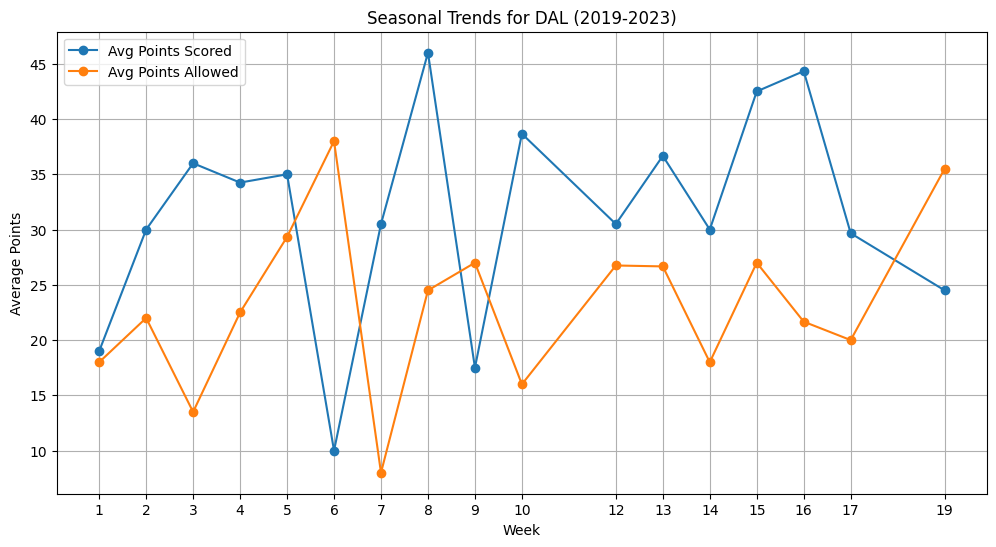

In [30]:
# Analyzing Seasonal Trends in Average Points Scored and Allowed by NFL Teams (2019-2023)

team = 'DAL'  # Example team

# Load the dataset
df = pd.read_csv('data/Games.csv')

# Filter for recent seasons if needed (e.g., 2019-2023)
df_recent = df[df['season'].isin([2019, 2020, 2021, 2022, 2023])]

# Group by team and week to calculate average points scored and allowed per week
team_weekly_performance = df_recent.groupby(['home_team', 'week']).agg(
    avg_points_scored=('home_score', 'mean'),
    avg_points_allowed=('away_score', 'mean')
).reset_index()

# Plotting seasonal trends for a selected team (e.g., DAL)
team_data = team_weekly_performance[team_weekly_performance['home_team'] == team]

plt.figure(figsize=(12, 6))
plt.plot(team_data['week'], team_data['avg_points_scored'], label='Avg Points Scored', marker='o')
plt.plot(team_data['week'], team_data['avg_points_allowed'], label='Avg Points Allowed', marker='o')
plt.title(f'Seasonal Trends for {team} (2019-2023)')
plt.xlabel('Week')
plt.ylabel('Average Points')
plt.xticks(team_data['week'])
plt.grid(True)
plt.legend()
plt.show()

### Defense <a id="defense"></a>

In [6]:
# Loop and rank all teams 2020-2024 seasons

# Function to calculate total defensive yards allowed for a given team and season
def calculate_team_total_yards_defensive_stats(team_abbreviation, season, data_df):
    # Filter for the specified season by extracting the season from the 'game_id' column
    data_df['season'] = data_df['game_id'].str.slice(0, 4).astype(int)

    # # Filter the data for the specific season
    # if season == 2024:
    #     # For the current season, only consider games played so far
    #     current_week = data_df[data_df['season'] == season]['game_id'].str.slice(5, 7).astype(int).max()  # Get the latest week
    #     season_games = data_df[(data_df['season'] == season) & (data_df['game_id'].str.slice(5, 7).astype(int) <= current_week)]
    # else:
    #     season_games = data_df[data_df['season'] == season]
    # Filter the data for the specific season
    if season == 2024:
        # Filter out unplayed games based on the key stats columns (assuming unplayed games have all zeros)
        season_games = data_df[(data_df['season'] == season) &
                               (data_df[['away_rush_yds', 'away_pass_yds', 'home_rush_yds', 'home_pass_yds']].sum(axis=1) > 0)]
    else:
        season_games = data_df[data_df['season'] == season]


    # Initialize lists for away and home games
    away_games = []
    home_games = []

    # Loop through each game and split game_id to determine home/away status
    for index, row in season_games.iterrows():
        game_id_parts = row['game_id'].split('_')
        game_season, week, away_team, home_team = game_id_parts

        # Convert the week to an integer to filter weeks 01-18
        week_num = int(week)

        if week_num > 18:
            continue  # Skip postseason weeks

        if away_team == team_abbreviation:
            away_games.append(row)  # The team was the away team in this game
        elif home_team == team_abbreviation:
            home_games.append(row)  # The team was the home team in this game

    # Convert lists to DataFrames for easier processing
    away_games_df = pd.DataFrame(away_games)
    home_games_df = pd.DataFrame(home_games)

    # Convert lists to DataFrames for easier processing
    away_games_df = pd.DataFrame(away_games)
    home_games_df = pd.DataFrame(home_games)

    if not away_games_df.empty and all(col in away_games_df for col in ['home_rush_yds', 'home_pass_yds']):
        away_defense_stats = away_games_df[['home_rush_yds', 'home_pass_yds']].sum()
    else:
        away_defense_stats = pd.Series({'home_rush_yds': 0, 'home_pass_yds': 0})
    
    if not home_games_df.empty and all(col in home_games_df for col in ['away_rush_yds', 'away_pass_yds']):
        home_defense_stats = home_games_df[['away_rush_yds', 'away_pass_yds']].sum()
    else:
        home_defense_stats = pd.Series({'away_rush_yds': 0, 'away_pass_yds': 0})

    # # For home games, we want the stats from the "away" columns (opponent is away team)
    # home_defense_stats = home_games_df[['away_rush_yds', 'away_pass_yds']].sum()

    # # For away games, we want the stats from the "home" columns (opponent is home team)
    # away_defense_stats = away_games_df[['home_rush_yds', 'home_pass_yds']].sum()

    # Combine rushing and passing yards for all games
    total_rush_yards_allowed = home_defense_stats['away_rush_yds'] + away_defense_stats['home_rush_yds']
    total_pass_yards_allowed = home_defense_stats['away_pass_yds'] + away_defense_stats['home_pass_yds']

    # Calculate total yards allowed (rushing + passing)
    total_yards_allowed = total_rush_yards_allowed + total_pass_yards_allowed

    # Number of games played by the team
    num_games = len(home_games_df) + len(away_games_df)

    # Calculate averages for total yards allowed
    defensive_summary = {
        "avg_total_yards_allowed": total_yards_allowed / num_games if num_games > 0 else 0,
        "avg_rush_yards_allowed": total_rush_yards_allowed / num_games if num_games > 0 else 0,
        "avg_pass_yards_allowed": total_pass_yards_allowed / num_games if num_games > 0 else 0,
        "season": season
    }

    return defensive_summary

# Load the dataset (assuming it's located in 'data/' folder)
file_path = 'data/all_team_game_logs.csv'
team_game_logs_df = pd.read_csv(file_path)

# List of all team abbreviations
teams = ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 
         'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LAC', 'LAR', 'LVR', 'MIA', 
         'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

# List to hold defensive stats for all teams
defensive_stats_list = []

# Loop through the seasons 2020 to 2023, and the played games in 2024
for season in range(2020, 2025):
    for team in teams:
        stats = calculate_team_total_yards_defensive_stats(team, season, team_game_logs_df)
        stats['team'] = team  # Add team abbreviation to the stats
        defensive_stats_list.append(stats)

# # Handle the 2024 season for only played games
# for team in teams:
#     stats = calculate_team_total_yards_defensive_stats(team, 2024, team_game_logs_df)
#     stats['team'] = team  # Add team abbreviation to the stats
#     defensive_stats_list.append(stats)

# Create a DataFrame from the defensive stats list
defensive_stats_df = pd.DataFrame(defensive_stats_list)

# Insert 'team' column at the first position
defensive_stats_df.insert(0, 'team', defensive_stats_df.pop('team'))

# Sort the DataFrame by average total yards allowed in descending order
sorted_defensive_stats_df = defensive_stats_df.sort_values(by='avg_pass_yards_allowed', ascending=False)
# sorted_defensive_stats_df = defensive_stats_df.sort_values(by=['season'], ascending=[True])

# Reset index and drop the old index
sorted_defensive_stats_df.reset_index(drop=True, inplace=True)

# Add a new column for row numbers
# sorted_defensive_stats_df.insert(0, 'No', sorted_defensive_stats_df.index + 1)

# Save to CSV without an index
sorted_defensive_stats_df.to_csv('data/team_defense_analysis_2020_2024.csv', index=False)

# Display the sorted DataFrame using Tabulate
# print(tabulate(sorted_defensive_stats_df, headers='keys', tablefmt='psql', showindex=False))

# Print confirmation message
print("Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.")

# Read the saved CSV file
final_df = pd.read_csv('data/team_defense_analysis_2020_2024.csv')

# Filter the DataFrame to include only the 2024 season
df_2024 = final_df[final_df['season'] == 2024].copy()

# Reset index for the filtered DataFrame (optional, for cleaner display)
df_2024.reset_index(drop=True, inplace=True)

# Add a new 'No' column specific to the 2024 data (optional)
# df_2024.insert(0, 'No', df_2024.index + 1)

# Display only the 2024 DataFrame using Tabulate
print('\n                                               2024 STATS')
print(tabulate(df_2024, headers='keys', tablefmt='psql', showindex=False))

# Print confirmation message
# print("Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.")

# Filter the DataFrame to include only the 2023 season
df_2023 = final_df[final_df['season'] == 2023].copy()

# Reset index for the filtered DataFrame (optional, for cleaner display)
df_2023.reset_index(drop=True, inplace=True)

# Add a new 'No' column specific to the 2024 data (optional)
# df_2024.insert(0, 'No', df_2024.index + 1)

# Display only the 2024 DataFrame using Tabulate
print('\n                                               2023 STATS')
print(tabulate(df_2023, headers='keys', tablefmt='psql', showindex=False))

# Print confirmation message
# print("Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.")

# !open data/team_defense_analysis_2020_2024.csv

Defensive stats for all teams have been saved to 'team_defense_analysis_2020_2024.csv'.

                                               2024 STATS
+--------+---------------------------+--------------------------+--------------------------+----------+
| team   |   avg_total_yards_allowed |   avg_rush_yards_allowed |   avg_pass_yards_allowed |   season |
|--------+---------------------------+--------------------------+--------------------------+----------|
| BAL    |                     306.5 |                     49.5 |                    257   |     2024 |
| KC     |                     386   |                    129.5 |                    256.5 |     2024 |
| JAX    |                     348.5 |                    103   |                    245.5 |     2024 |
| TB     |                     381   |                    138.5 |                    242.5 |     2024 |
| PHI    |                     399.5 |                    157.5 |                    242   |     2024 |
| NE     |           

### Sacks <a id="sacks"></a>

In [3]:
# Sacks Given & Taken

# years = [2021, 2022, 2023, 2024]
years = [2024]

file_path = 'data/all_team_game_logs.csv'
df = pd.read_csv(file_path)

unplayed_games = df[
    df['game_id'].str.contains('2024') &  # Check if 'game_id' contains "2024"
    ((df['home_pts_off'].isnull() | (df['home_pts_off'] == 0)) &
     (df['away_pts_off'].isnull() | (df['away_pts_off'] == 0)))
]
unplayed_game_ids = unplayed_games['game_id'].tolist()
df = df[~df['game_id'].isin(unplayed_game_ids)]
# df.to_csv('data/all_team_game_logs.csv', index=False)
print("Unplayed games removed and updated CSV saved.")

# Extract year and week from 'game_id'
df[['year', 'week', 'away_team', 'home_team']] = df['game_id'].str.split('_', expand=True).iloc[:, :4]
df['year'] = df['year'].astype(int)
df['week'] = df['week'].astype(int)

for year in years:
    df_2023 = df[(df['year'] == year) & (df['week'] <= 18)]
    
    # Initialize a dictionary to track sacks made and sacks taken
    sack_stats = {
        'team': [],
        'sacks_made': [],
        'sacks_taken': []
    }
    
    # List of all 32 NFL teams
    teams = [
        'ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE',
        'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC',
        'LV', 'LAC', 'LAR', 'MIA', 'MIN', 'NE', 'NO', 'NYG',
        'NYJ', 'PHI', 'PIT', 'SF', 'SEA', 'TB', 'TEN', 'WAS'
    ]
    
    # Calculate the sacks made and sacks taken for each team
    for team in teams:
        # Sacks made by the team's defense (home and away games)
        sacks_made = df_2023.loc[(df_2023['home_team'] == team), 'away_pass_sacked'].sum() + \
                     df_2023.loc[(df_2023['away_team'] == team), 'home_pass_sacked'].sum()
        
        # Sacks taken (against the team) - includes home and away games
        sacks_taken = df_2023.loc[(df_2023['home_team'] == team), 'home_pass_sacked'].sum() + \
                      df_2023.loc[(df_2023['away_team'] == team), 'away_pass_sacked'].sum()
        
        # Store results
        sack_stats['team'].append(team)
        sack_stats['sacks_made'].append(sacks_made)
        sack_stats['sacks_taken'].append(sacks_taken)
    
    # Convert the dictionary to a DataFrame
    sack_stats_df = pd.DataFrame(sack_stats)
    
    # # Calculate average sacks made and taken (if needed by game or for total analysis)
    sack_stats_df['average_sacks_made'] = sack_stats_df['sacks_made'] / len(df_2023['week'].unique())
    sack_stats_df['average_sacks_taken'] = sack_stats_df['sacks_taken'] / len(df_2023['week'].unique())
    
    sacks_made_sorted = sack_stats_df[['team', 'sacks_made', 'average_sacks_made']].sort_values(by='sacks_made', ascending=False)
    sacks_taken_sorted = sack_stats_df[['team', 'sacks_taken', 'average_sacks_taken']].sort_values(by='sacks_taken', ascending=False)
    
    # Use tabulate to print both tables
    # print("Teams Sorted by Sacks Made:")
    # print(tabulate(sacks_made_sorted, headers='keys', tablefmt='grid'))
    display(sacks_made_sorted)
    sacks_made_sorted.to_csv(f'data/sacks_made_sorted_{year}.csv', index=False)
    print()
    print()
    
    # print("\nTeams Sorted by Sacks Taken:")
    # print(tabulate(sacks_taken_sorted, headers='keys', tablefmt='grid'))
    display(sacks_taken_sorted)
    sacks_taken_sorted.to_csv(f'data/sacks_taken_sorted_{year}.csv', index=False)
    print()
    print()
# !open data/sacks_taken_sorted_2024.csv

Unplayed games removed and updated CSV saved.


,team,sacks_made,average_sacks_made
20,MIN,11.0,5.5
12,HOU,9.0,4.5
0,ARI,7.0,3.5
2,BAL,7.0,3.5
24,NYJ,7.0,3.5
7,CLE,7.0,3.5
8,DAL,7.0,3.5
10,DET,7.0,3.5
22,NO,7.0,3.5
17,LAC,6.0,3.0


,team,sacks_taken,average_sacks_taken
5,CHI,9.0,4.5
27,SF,9.0,4.5
7,CLE,8.0,4.0
31,WAS,7.0,3.5
18,LAR,7.0,3.5
30,TEN,7.0,3.5
12,HOU,7.0,3.5
14,JAX,7.0,3.5
29,TB,6.0,3.0
4,CAR,6.0,3.0


In [2]:
import pandas as pd

sacks_made_2023 = pd.read_csv('data/sacks_made_sorted_2023.csv')
sacks_made_2024 = pd.read_csv('data/sacks_made_sorted_2024.csv')
sacks_taken_2023 = pd.read_csv('data/sacks_taken_sorted_2024.csv')
sacks_taken_2024 = pd.read_csv('data/sacks_taken_sorted_2024.csv')

# Define matchups for 2024-09-22
matchups = [
    ('NYG', 'CLE'), ('CHI', 'IND'), ('HOU', 'MIN'), ('PHI', 'NO'), 
    ('LAC', 'PIT'), ('DEN', 'TB'), ('GB', 'TEN'), ('CAR', 'LV'), ('MIA', 'SEA')
]

# Define thresholds for color coding (adjust if needed)
advantage_threshold = 2.5

# ANSI color codes
GREEN = '\033[1;92m'  # Bold bright green
RED = '\033[1;91m'    # Bold bright red
RESET = '\033[0m'     # Reset to default color

# Step 1: Print upcoming matchups for 2024-09-22
print("Upcoming Matchups:\n")
for i, matchup in enumerate(matchups, start=1):
    team1, team2 = matchup

    # Sacks made and taken in 2024 for the matchup
    team1_sacks_made = sacks_made_2024[sacks_made_2024['team'] == team1]['sacks_made'].values[0]
    team2_sacks_made = sacks_made_2024[sacks_made_2024['team'] == team2]['sacks_made'].values[0]
    
    team1_sacks_taken = sacks_taken_2024[sacks_taken_2024['team'] == team1]['sacks_taken'].values[0]
    team2_sacks_taken = sacks_taken_2024[sacks_taken_2024['team'] == team2]['sacks_taken'].values[0]
    
    team1_advantage = team1_sacks_made - team1_sacks_taken
    team2_advantage = team2_sacks_made - team2_sacks_taken
    
    # Apply color formatting
    if team1_advantage >= advantage_threshold:
        team1_line = f"{GREEN}{team1} advantage/disadvantage: {team1_advantage}{RESET}"
    elif team1_advantage <= -advantage_threshold:
        team1_line = f"{RED}{team1} advantage/disadvantage: {team1_advantage}{RESET}"
    else:
        team1_line = f"{team1} advantage/disadvantage: {team1_advantage}"

    if team2_advantage >= advantage_threshold:
        team2_line = f"{GREEN}{team2} advantage/disadvantage: {team2_advantage}{RESET}"
    elif team2_advantage <= -advantage_threshold:
        team2_line = f"{RED}{team2} advantage/disadvantage: {team2_advantage}{RESET}"
    else:
        team2_line = f"{team2} advantage/disadvantage: {team2_advantage}"
    
    # Print the matchup
    print(f"{i}. {team1} vs {team2}:")
    print(f"{team1} sacks made: {team1_sacks_made}")
    print(f"{team1} sacks against: {team1_sacks_taken}")
    print(f"{team2} sacks made: {team2_sacks_made}")
    print(f"{team2} sacks against: {team2_sacks_taken}")
    print(team1_line)
    print(team2_line + "\n")

Upcoming Matchups:

1. NYG vs CLE:
NYG sacks made: 6.0
NYG sacks against: 6.0
CLE sacks made: 7.0
CLE sacks against: 8.0
NYG advantage/disadvantage: 0.0
CLE advantage/disadvantage: -1.0

2. CHI vs IND:
CHI sacks made: 6.0
CHI sacks against: 9.0
IND sacks made: 4.0
IND sacks against: 3.0
CHI advantage/disadvantage: -3.0
IND advantage/disadvantage: 1.0

3. HOU vs MIN:
HOU sacks made: 9.0
HOU sacks against: 7.0
MIN sacks made: 11.0
MIN sacks against: 5.0
HOU advantage/disadvantage: 2.0
MIN advantage/disadvantage: 6.0

4. PHI vs NO:
PHI sacks made: 3.0
PHI sacks against: 3.0
NO sacks made: 7.0
NO sacks against: 2.0
PHI advantage/disadvantage: 0.0
NO advantage/disadvantage: 5.0

5. LAC vs PIT:
LAC sacks made: 6.0
LAC sacks against: 2.0
PIT sacks made: 4.0
PIT sacks against: 4.0
LAC advantage/disadvantage: 4.0
PIT advantage/disadvantage: 0.0

6. DEN vs TB:
DEN sacks made: 4.0
DEN sacks against: 4.0
TB sacks made: 2.0
TB sacks against: 6.0
DEN advantage/disadvantage: 0.0
TB advantage/disadvan

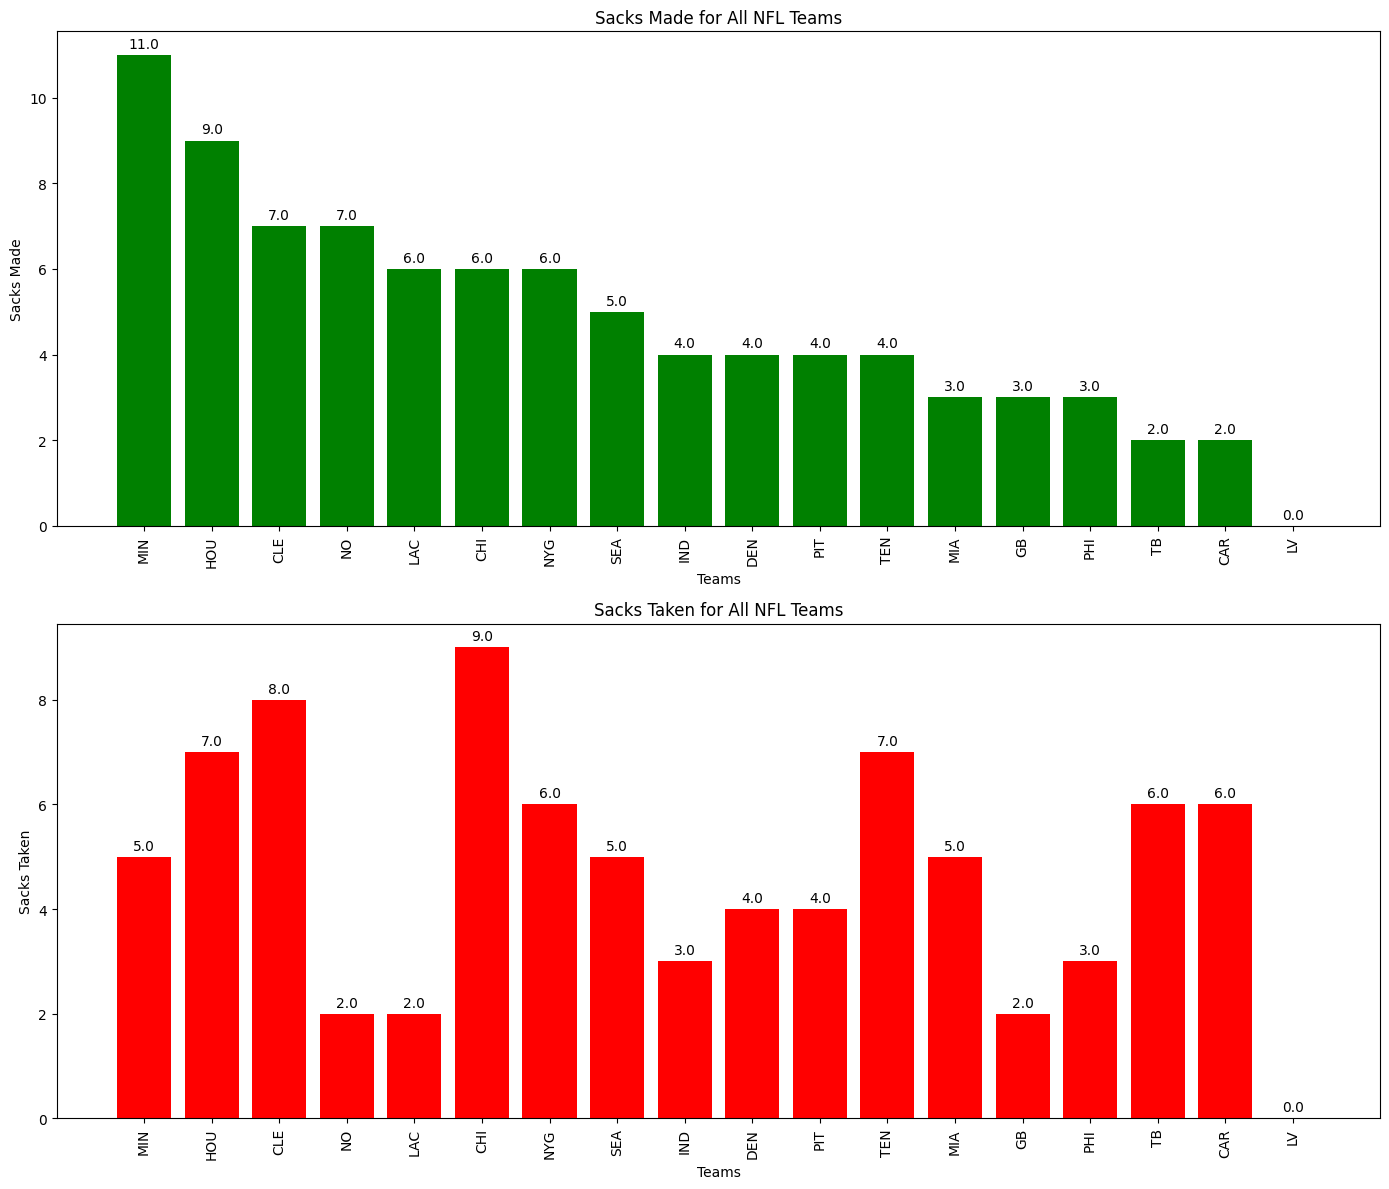

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Get the list of teams from the unique team values in your dataset
teams = sacks_made_2024_filtered['team'].tolist()

# Ensure we match the correct sacks made and sacks taken for each team
sacks_made = [sacks_made_2024_filtered[sacks_made_2024_filtered['team'] == team]['sacks_made'].values[0] for team in teams]
sacks_taken = [sacks_taken_2024_filtered[sacks_taken_2024_filtered['team'] == team]['sacks_taken'].values[0] for team in teams]

# Create the x locations for the teams
x = np.arange(len(teams))  # Label locations

# Create two subplots: one for sacks made and one for sacks taken
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Bar chart for sacks made
rects1 = ax1.bar(x, sacks_made, color='green')
ax1.set_xlabel('Teams')
ax1.set_ylabel('Sacks Made')
ax1.set_title('Sacks Made for All NFL Teams')
ax1.set_xticks(x)
ax1.set_xticklabels(teams, rotation=90)  # Rotate team labels for better visibility

# Bar chart for sacks taken
rects2 = ax2.bar(x, sacks_taken, color='red')
ax2.set_xlabel('Teams')
ax2.set_ylabel('Sacks Taken')
ax2.set_title('Sacks Taken for All NFL Teams')
ax2.set_xticks(x)
ax2.set_xticklabels(teams, rotation=90)

# Add value labels on top of the bars
def autolabel(rects, ax):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add value labels to both bar charts
autolabel(rects1, ax1)
autolabel(rects2, ax2)

# Ensure layout fits well with rotated labels
plt.tight_layout()
plt.show()


### Offense <a id="offense"></a>

### 1H vs 2H <a id="offense"></a>

NFL Teams Ranked by 1st Half Scoring (2023 Season):


,Team,1st_half_points
8,Dallas Cowboys,16.833333
19,Miami Dolphins,16.166667
10,Detroit Lions,15.250000
2,Baltimore Ravens,14.631579
27,San Francisco 49ers,14.550000
3,Buffalo Bills,14.210526
15,Kansas City Chiefs,13.904762
7,Cleveland Browns,12.611111
13,Indianapolis Colts,12.588235
18,Los Angeles Rams,12.222222



NFL Teams Ranked by 2nd Half Scoring (2023 Season):


,Team,2nd_half_points
27,San Francisco 49ers,13.850000
8,Dallas Cowboys,13.222222
11,Green Bay Packers,13.157895
2,Baltimore Ravens,12.789474
22,New Orleans Saints,12.764706
25,Philadelphia Eagles,12.388889
14,Jacksonville Jaguars,12.352941
3,Buffalo Bills,12.263158
10,Detroit Lions,12.100000
19,Miami Dolphins,11.777778





NFL Teams Ranked by 1st Half Scoring (2024 Season):


,Team,1st_half_points
3,Buffalo Bills,22.666667
22,New Orleans Saints,22.666667
0,Arizona Cardinals,17.000000
11,Green Bay Packers,16.333333
28,Seattle Seahawks,14.333333
8,Dallas Cowboys,14.000000
20,Minnesota Vikings,13.666667
2,Baltimore Ravens,13.333333
27,San Francisco 49ers,12.333333
31,Washington Commanders,12.333333



NFL Teams Ranked by 2nd Half Scoring (2024 Season):


,Team,2nd_half_points
25,Philadelphia Eagles,15.333333
13,Indianapolis Colts,14.666667
3,Buffalo Bills,14.666667
20,Minnesota Vikings,14.666667
18,Los Angeles Rams,14.666667
31,Washington Commanders,14.000000
5,Chicago Bears,13.333333
24,New York Jets,13.000000
6,Cincinnati Bengals,13.000000
15,Kansas City Chiefs,13.000000


1st Half Comparison (2023 vs 2024):
                     Team  1st_half_points_2023  1st_half_points_2024
0       Arizona Cardinals             10.352941             17.000000
1         Atlanta Falcons              8.941176             10.000000
2        Baltimore Ravens             14.631579             13.333333
3           Buffalo Bills             14.210526             22.666667
4       Carolina Panthers              6.117647              8.000000
5           Chicago Bears             11.294118              4.333333
6      Cincinnati Bengals             10.647059              9.666667
7        Cleveland Browns             12.611111              7.666667
8          Dallas Cowboys             16.833333             14.000000
9          Denver Broncos              9.882353             11.000000
10          Detroit Lions             15.250000             12.000000
11      Green Bay Packers             10.631579             16.333333
12         Houston Texans             11.631579       

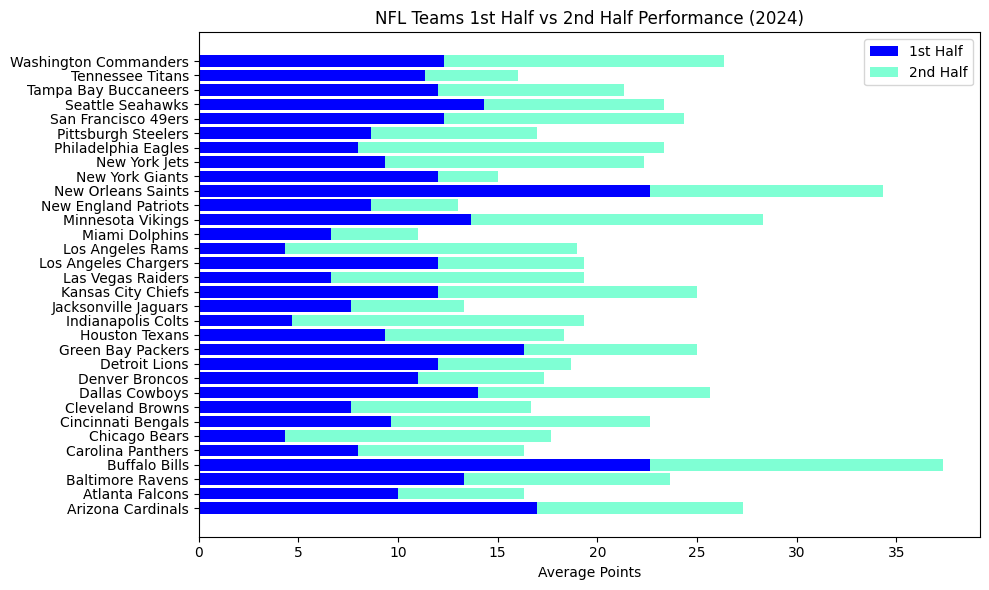

In [24]:
# 1H vs 2H points scored 2023 & 2024

nfl_data = pd.read_csv('data/box_scores.csv')

nfl_data['Season'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{4})')
nfl_data['Season'] = nfl_data['Season'].astype(int)

# Extract the year and the month from the URL using regex
nfl_data['GameDate'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{8})')
nfl_data['Year'] = nfl_data['GameDate'].str[:4].astype(int)
nfl_data['Month'] = nfl_data['GameDate'].str[4:6].astype(int)

# Correct for games played in January, February, and March
nfl_data['Season'] = nfl_data.apply(lambda row: row['Year'] - 1 if row['Month'] in [1, 2, 3] else row['Year'], axis=1)

nfl_data_2023 = nfl_data[nfl_data['Season'] == 2023].copy()

nfl_data_2023.loc[:, '1st_half_points'] = nfl_data_2023['1'] + nfl_data_2023['2']
nfl_data_2023.loc[:, '2nd_half_points'] = nfl_data_2023['3'] + nfl_data_2023['4']

team_performance_2023 = nfl_data_2023.groupby('Team').agg({
    '1st_half_points': 'mean',
    '2nd_half_points': 'mean',
    'Final': 'mean'
}).reset_index()

first_half_scoring_2023 = team_performance_2023.sort_values(by='1st_half_points', ascending=False)
second_half_scoring_2023 = team_performance_2023.sort_values(by='2nd_half_points', ascending=False)

print("NFL Teams Ranked by 1st Half Scoring (2023 Season):")
display(first_half_scoring_2023[['Team', '1st_half_points']])
print("\nNFL Teams Ranked by 2nd Half Scoring (2023 Season):")
display(second_half_scoring_2023[['Team', '2nd_half_points']])
print('\n\n')

nfl_data = pd.read_csv('data/box_scores.csv')

nfl_data['Season'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{4})')
nfl_data['Season'] = nfl_data['Season'].astype(int)

# Extract the year and the month from the URL using regex
nfl_data['GameDate'] = nfl_data['URL'].str.extract(r'/boxscores/(\d{8})')
nfl_data['Year'] = nfl_data['GameDate'].str[:4].astype(int)
nfl_data['Month'] = nfl_data['GameDate'].str[4:6].astype(int)

# Correct for games played in January, February, and March
nfl_data['Season'] = nfl_data.apply(lambda row: row['Year'] - 1 if row['Month'] in [1, 2, 3] else row['Year'], axis=1)

nfl_data_2024 = nfl_data[nfl_data['Season'] == 2024].copy()

nfl_data_2024.loc[:, '1st_half_points'] = nfl_data_2024['1'] + nfl_data_2024['2']
nfl_data_2024.loc[:, '2nd_half_points'] = nfl_data_2024['3'] + nfl_data_2024['4']

team_performance_2024 = nfl_data_2024.groupby('Team').agg({
    '1st_half_points': 'mean',
    '2nd_half_points': 'mean',
    'Final': 'mean'
}).reset_index()

first_half_scoring_2024 = team_performance_2024.sort_values(by='1st_half_points', ascending=False)
second_half_scoring_2024 = team_performance_2024.sort_values(by='2nd_half_points', ascending=False)

print("NFL Teams Ranked by 1st Half Scoring (2024 Season):")
display(first_half_scoring_2024[['Team', '1st_half_points']])

print("\nNFL Teams Ranked by 2nd Half Scoring (2024 Season):")
display(second_half_scoring_2024[['Team', '2nd_half_points']])

# Compare the 1st half and 2nd half scoring for both seasons
comparison_1st_half = pd.merge(team_performance_2023[['Team', '1st_half_points']], 
                               team_performance_2024[['Team', '1st_half_points']], 
                               on='Team', suffixes=('_2023', '_2024'))

comparison_2nd_half = pd.merge(team_performance_2023[['Team', '2nd_half_points']], 
                               team_performance_2024[['Team', '2nd_half_points']], 
                               on='Team', suffixes=('_2023', '_2024'))

# Display the results
print("1st Half Comparison (2023 vs 2024):")
print(comparison_1st_half)
print("\n2nd Half Comparison (2023 vs 2024):")
print(comparison_2nd_half)
print('\n\n')

# Create the bar chart for the 2024 season
plt.figure(figsize=(10, 6))
plt.barh(team_performance_2024['Team'], team_performance_2024['1st_half_points'], color='blue', label='1st Half')
plt.barh(team_performance_2024['Team'], team_performance_2024['2nd_half_points'], 
         left=team_performance_2024['1st_half_points'], color='aquamarine', label='2nd Half')
plt.xlabel('Average Points')
plt.title('NFL Teams 1st Half vs 2nd Half Performance (2024)')
plt.legend()
plt.tight_layout()
plt.show()


---

---

## PLAYER TRENDS <a id="player-trends"></a>

### General <a id="general_players"></a>

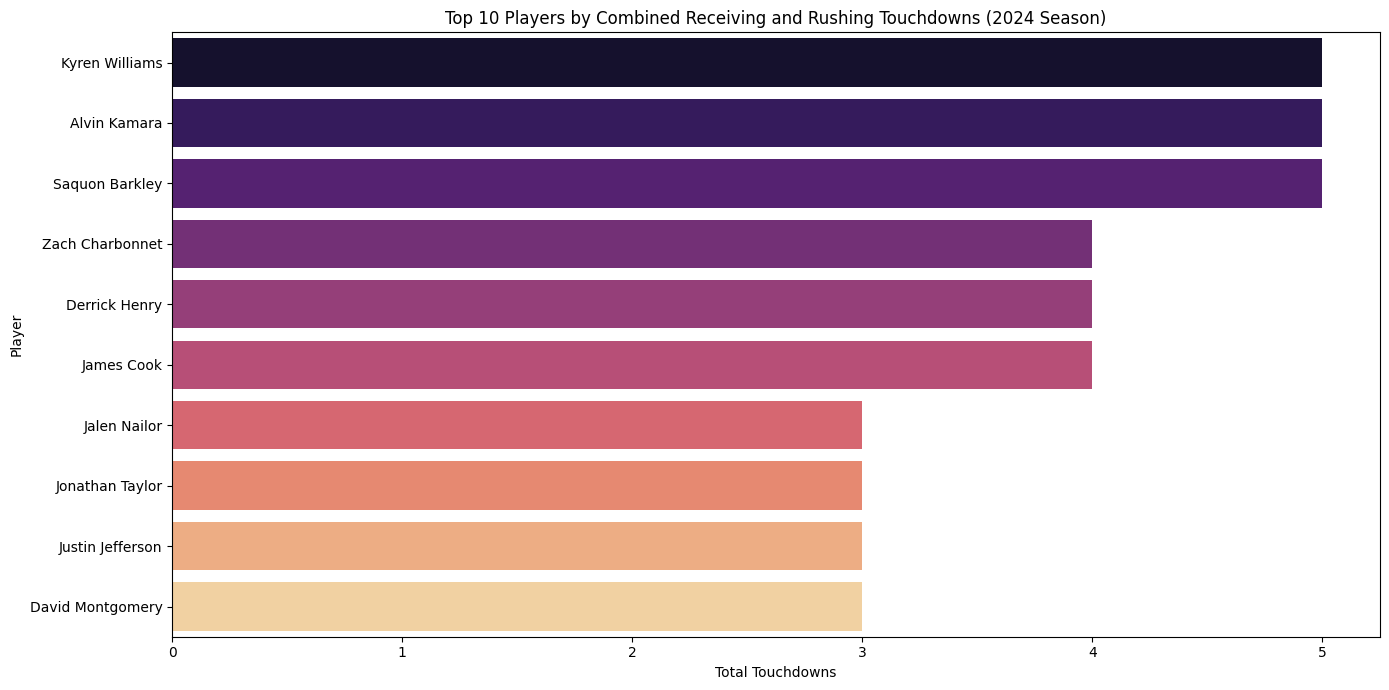

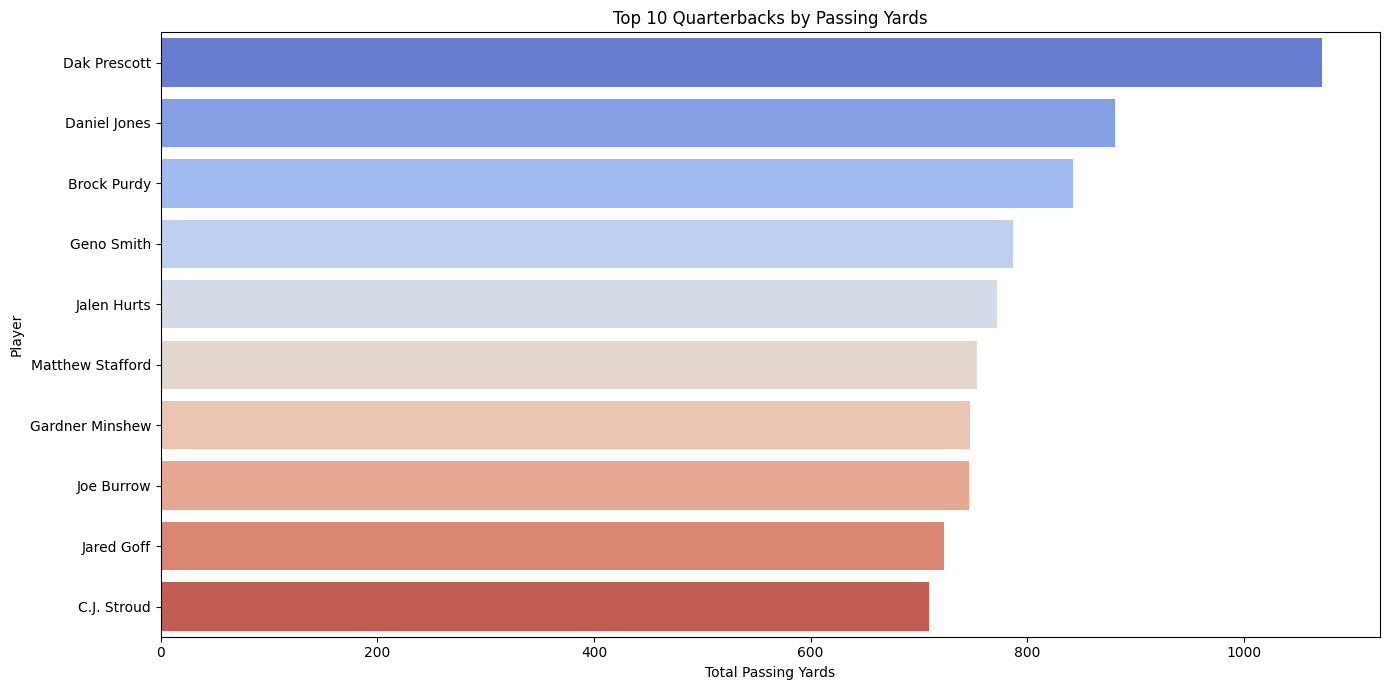

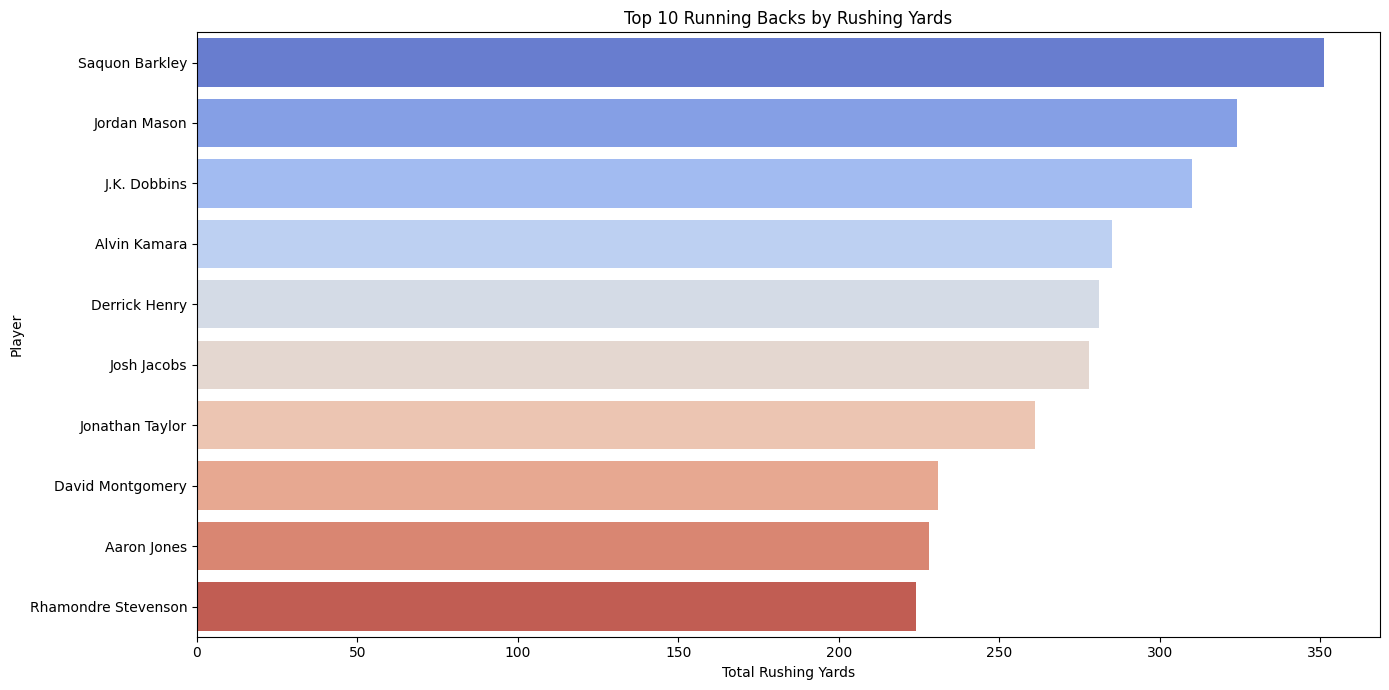

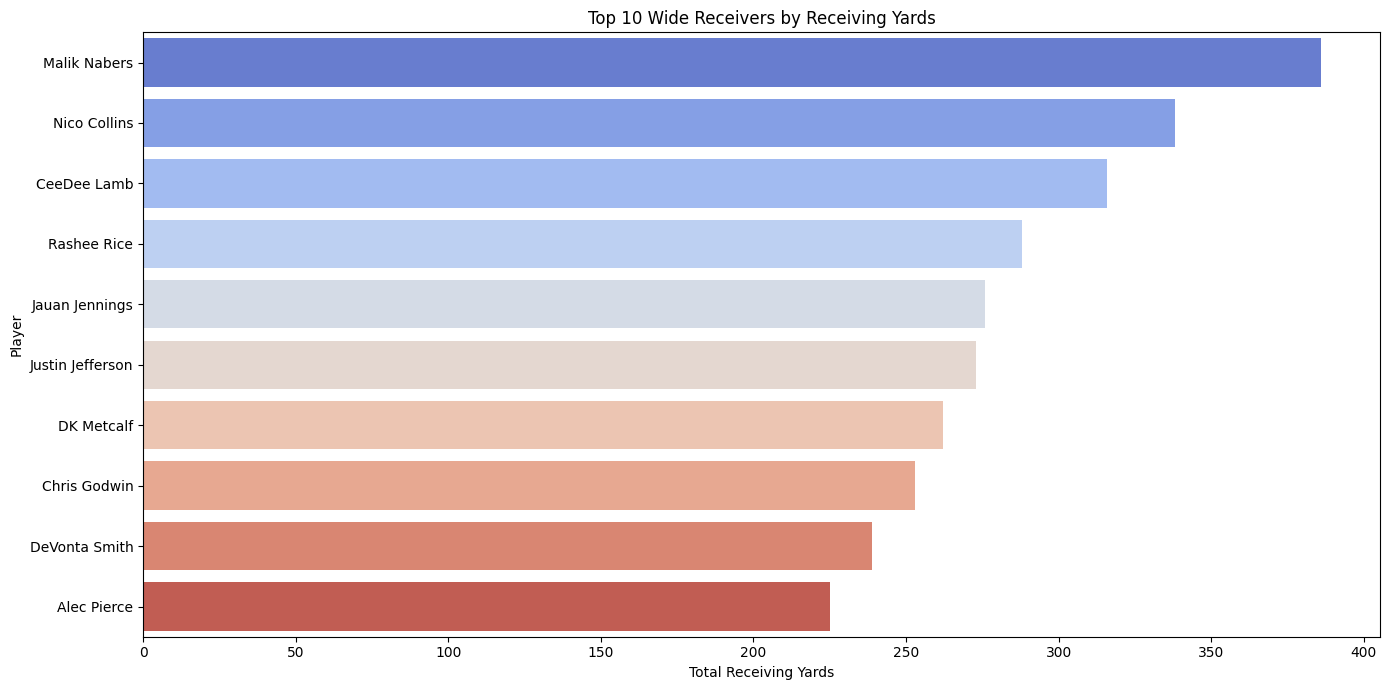

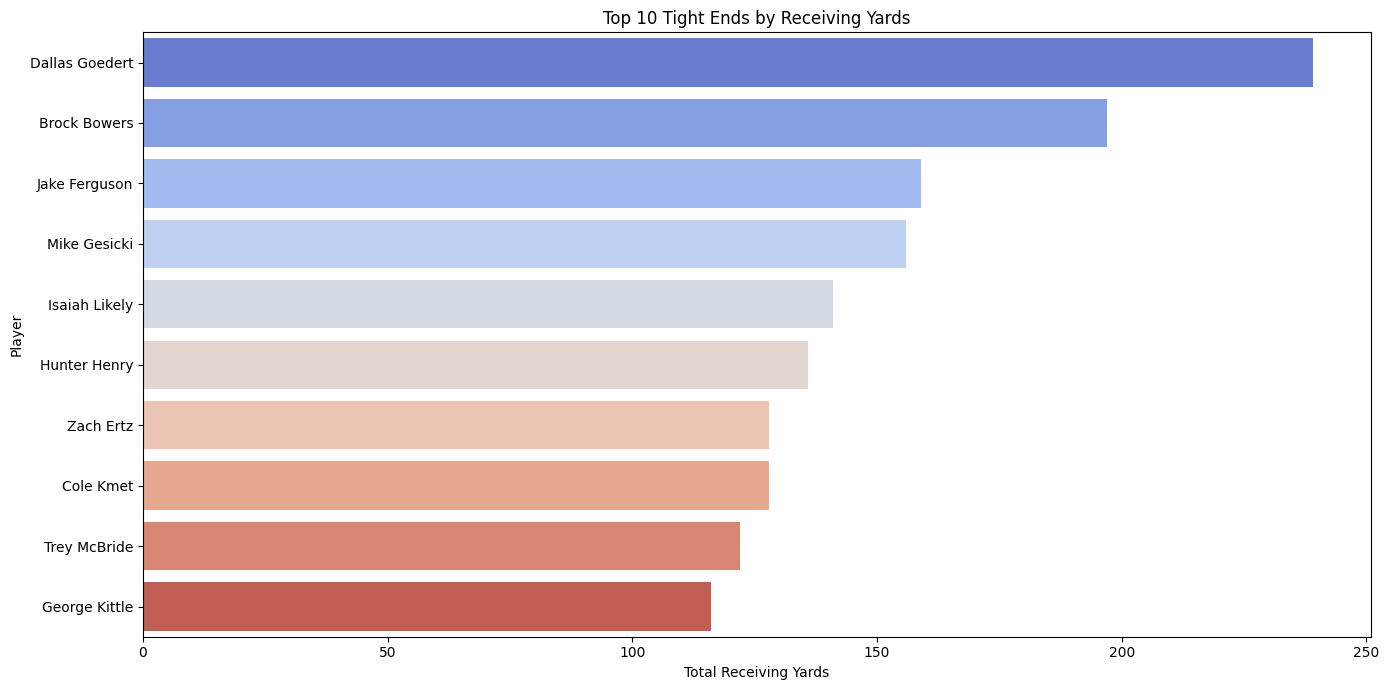

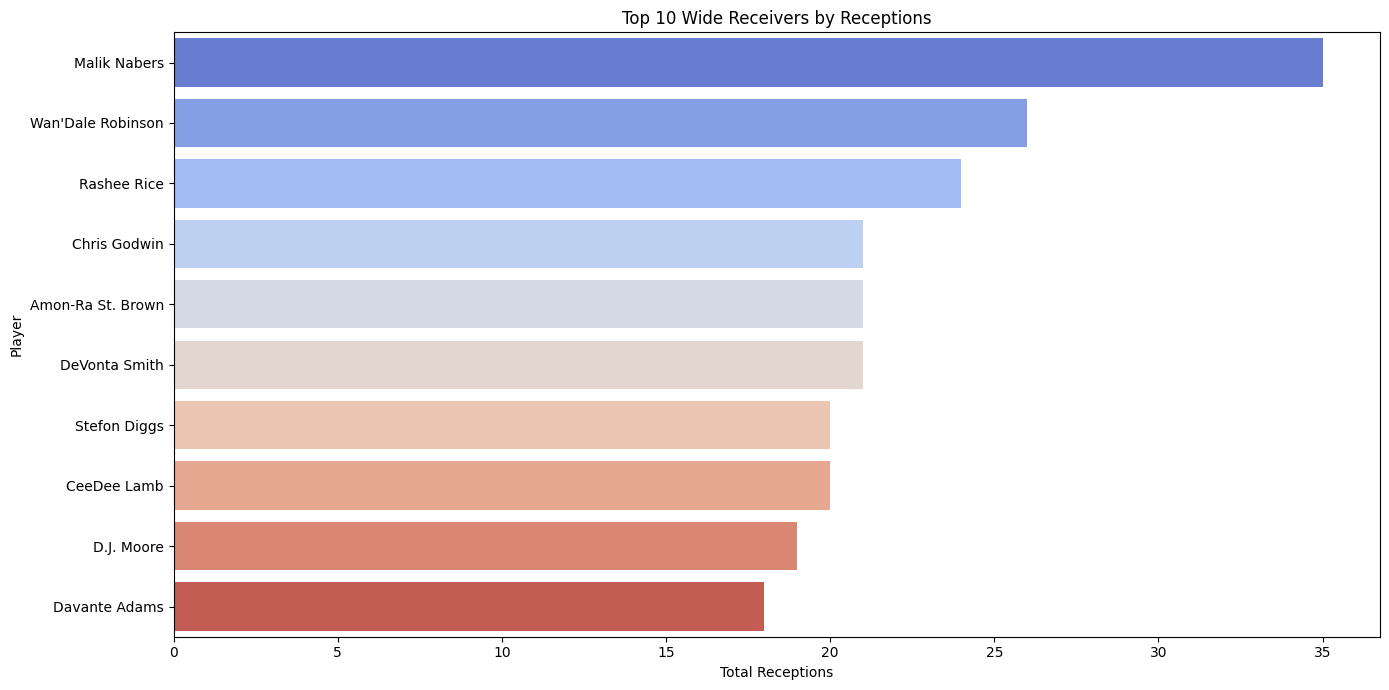

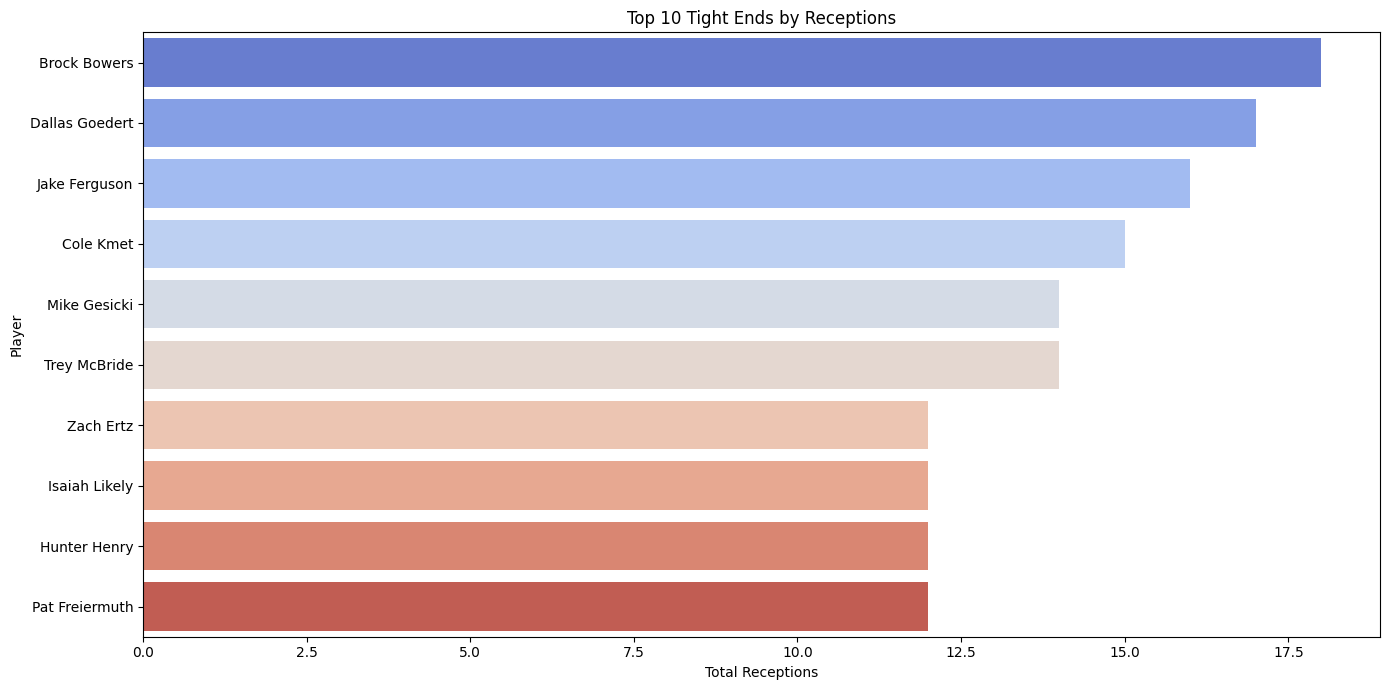

In [18]:
# Leaders

conn = sqlite3.connect('data/nfl.db')
cursor = conn.cursor()
teams_df = pd.read_sql_query("SELECT * FROM Teams", conn)
games_df = pd.read_sql_query("SELECT * FROM Games", conn) # ALL TIME
# games_df = pd.read_sql_query("SELECT * FROM Games WHERE season = 2024", conn) # ONLY 2024
# playerstats_df = pd.read_sql_query("SELECT * FROM PlayerStats", conn)
playerstats_df = pd.read_sql_query("SELECT * FROM PlayerStats WHERE season = 2024", conn) # ONLY 2024
conn.close()

# Top Players by Combined Receiving and Rushing Touchdowns
top_players_td = playerstats_df.groupby('player_display_name').agg({
    'receiving_tds': 'sum',
    'rushing_tds': 'sum'
}).reset_index()
top_players_td['total_tds'] = top_players_td['receiving_tds'] + top_players_td['rushing_tds']
top_players_td = top_players_td.sort_values(by='total_tds', ascending=False).head(10)
plt.figure(figsize=(14, 7))
sns.barplot(x='total_tds', y='player_display_name', data=top_players_td, palette='magma', hue='player_display_name', dodge=False, legend=False)
plt.title('Top 10 Players by Combined Receiving and Rushing Touchdowns (2024 Season)')
plt.xlabel('Total Touchdowns')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# Top Quarterbacks Performance
top_qbs = playerstats_df[playerstats_df['position'] == 'QB'].groupby('player_display_name').agg({
    'passing_yards': 'sum', 'passing_tds': 'sum'
}).sort_values(by='passing_yards', ascending=False).head(10).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='passing_yards', y='player_display_name', data=top_qbs, palette='coolwarm', hue='player_display_name', dodge=False, legend=False)
plt.title('Top 10 Quarterbacks by Passing Yards')
plt.xlabel('Total Passing Yards')
plt.ylabel('Player')
plt.tight_layout()
plt.savefig('top_quarterbacks.png')
plt.show()

# Top Running Backs Performance
top_rbs = playerstats_df[playerstats_df['position'] == 'RB'].groupby('player_display_name').agg({
    'rushing_yards': 'sum', 'rushing_tds': 'sum'
}).sort_values(by='rushing_yards', ascending=False).head(10).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='rushing_yards', y='player_display_name', data=top_rbs, hue='player_display_name', dodge=False, palette='coolwarm', legend=False)
plt.title('Top 10 Running Backs by Rushing Yards')
plt.xlabel('Total Rushing Yards')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# Top Wide Receivers by Receiving Yards
top_wrs = playerstats_df[playerstats_df['position'] == 'WR'].groupby('player_display_name').agg({
    'receiving_yards': 'sum', 'receiving_tds': 'sum'
}).sort_values(by='receiving_yards', ascending=False).head(10).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='receiving_yards', y='player_display_name', data=top_wrs, palette='coolwarm', hue='player_display_name', dodge=False, legend=False)
plt.title('Top 10 Wide Receivers by Receiving Yards')
plt.xlabel('Total Receiving Yards')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# Top Tight Ends by Receiving Yards
top_wrs = playerstats_df[playerstats_df['position'] == 'TE'].groupby('player_display_name').agg({
    'receiving_yards': 'sum', 'receiving_tds': 'sum'
}).sort_values(by='receiving_yards', ascending=False).head(10).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='receiving_yards', y='player_display_name', data=top_wrs, palette='coolwarm', hue='player_display_name', dodge=False, legend=False)
plt.title('Top 10 Tight Ends by Receiving Yards')
plt.xlabel('Total Receiving Yards')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# Top Wide Receivers by Receptions
top_wrs_receptions = playerstats_df[playerstats_df['position'] == 'WR'].groupby('player_display_name').agg({
    'receptions': 'sum', 'receiving_tds': 'sum'
}).sort_values(by='receptions', ascending=False).head(10).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='receptions', y='player_display_name', data=top_wrs_receptions, palette='coolwarm', hue='player_display_name', dodge=False, legend=False)
plt.title('Top 10 Wide Receivers by Receptions')
plt.xlabel('Total Receptions')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

# Top Tight Ends by Receptions
top_tes_receptions = playerstats_df[playerstats_df['position'] == 'TE'].groupby('player_display_name').agg({
    'receptions': 'sum', 'receiving_tds': 'sum'
}).sort_values(by='receptions', ascending=False).head(10).reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='receptions', y='player_display_name', data=top_tes_receptions, palette='coolwarm', hue='player_display_name', dodge=False, legend=False)
plt.title('Top 10 Tight Ends by Receptions')
plt.xlabel('Total Receptions')
plt.ylabel('Player')
plt.tight_layout()
plt.show()

### Quarterbacks <a id="quarterbacks"></a>

In [ ]:
# QB Rushing Touchdowns 

df_updated = pd.read_csv('data/all_passing_rushing_receiving.csv')

# Filter the dataset for Baker Mayfield's entire career and focus on rushing touchdowns
baker_mayfield_rushing_career = df_updated[df_updated['player'] == 'Baker Mayfield']

# Sum the rushing touchdowns and get the detailed breakdown
baker_mayfield_rushing_td_career = baker_mayfield_rushing_career['rush_td'].sum()

# Get the details of games where he scored rushing touchdowns
baker_mayfield_rushing_career_details = baker_mayfield_rushing_career[baker_mayfield_rushing_career['rush_td'] > 0][['game_id', 'opponent_team', 'rush_td']]

# Extract the year and week from the game_id
baker_mayfield_rushing_career_details['Year'] = baker_mayfield_rushing_career_details['game_id'].str[:4]
baker_mayfield_rushing_career_details['Week'] = baker_mayfield_rushing_career_details['game_id'].str[5:7]

baker_mayfield_rushing_td_career, baker_mayfield_rushing_career_details


### Running Backs <a id="running-backs"></a>

### Wide Receivers <a id="wide-receivers"></a>

In [21]:
# Single WR Stats - Longest Reception & Matchup Stats

player_name = 'Tyreek Hill'
# player_name = 'Jaylen Waddle'
# player_name = 'Dawson Knox'
# player_name = 'Justin Jefferson'
opponent_team = 'SEA'

all_stats_df = pd.read_csv('data/all_passing_rushing_receiving.csv')

def get_player_longest_reception_stats(player_name, opponent_team=None):
    player_data = all_stats_df[all_stats_df['player'] == player_name]

    if 'rec_long' not in player_data.columns:
        return f"No reception data available for {player_name}"

    longest_reception = player_data['rec_long'].max()  # Career-longest reception
    total_games = player_data.shape[0]
    opponent_insights = None
    opponent_data = None
    if opponent_team:
        # Filter the data based on the specified opponent team
        opponent_data = player_data[player_data['opponent_team'] == opponent_team].drop_duplicates(subset=['game_id', 'rec_yds'])
        
        if opponent_data.empty:
            opponent_insights = f"No data available for {player_name} against {opponent_team}"
        else:
            opponent_insights = {
                "Opponent": opponent_team,
                "Longest Reception vs Opponent": opponent_data['rec_long'].max(),
                "Average Longest Reception vs Opponent": opponent_data['rec_long'].mean(),
                "Total Games vs Opponent": opponent_data.shape[0],
                "Games with 30+ Yard Reception vs Opponent": opponent_data[opponent_data['rec_long'] >= 30].shape[0],
                "Average Receptions per Game vs Opponent": opponent_data['rec'].mean(),
                "Average Receiving Yards per Game vs Opponent": opponent_data['rec_yds'].mean(),
                "Receiving Touchdowns vs Opponent": opponent_data['rec_td'].sum(),
                "Average Targets per Game vs Opponent": opponent_data['targets'].mean() if 'targets' in opponent_data.columns else "N/A",
            }

    else:
        opponent_insights = "No opponent provided."

    career_insights = {
        "Player": player_name,
        "Career Longest Reception": longest_reception,
        "Total Games Played": total_games,
    }

    return career_insights, opponent_insights, opponent_data

career_insights, opponent_insights, opponent_data = get_player_longest_reception_stats(player_name, opponent_team)

print("\nCAREER INSIGHTS:")
for key, value in career_insights.items():
    print(f"{key}: {value}")
print("\nOPPONENT INSIGHTS:")
if isinstance(opponent_insights, dict):
    for key, value in opponent_insights.items():
        print(f"{key}: {value}")
else:
    print(opponent_insights)
if opponent_data is not None:
    print("\nGAMES AGAINST OPPONENT:")
    for index, row in opponent_data.iterrows():
        print(f"{index + 1}. Game ID: {row['game_id']}, Rec Yards: {row['rec_yds']}")


CAREER INSIGHTS:
Player: Tyreek Hill
Career Longest Reception: 80.0
Total Games Played: 142

OPPONENT INSIGHTS:
Opponent: SEA
Longest Reception vs Opponent: 32.0
Average Longest Reception vs Opponent: 24.5
Total Games vs Opponent: 2
Games with 30+ Yard Reception vs Opponent: 1
Average Receptions per Game vs Opponent: 3.5
Average Receiving Yards per Game vs Opponent: 57.0
Receiving Touchdowns vs Opponent: 0.0
Average Targets per Game vs Opponent: 7.0

GAMES AGAINST OPPONENT:
22468. Game ID: 2024_03_MIA_SEA, Rec Yards: 40.0
27451. Game ID: 2018_16_KC_SEA, Rec Yards: 74.0


In [32]:
# Longest Reception in All Career Games

data = pd.read_csv('data/all_passing_rushing_receiving.csv')

player_name = 'CeeDee Lamb'
# player_name = 'Tyreek Hill'
# player_name = 'Jameson Williams'
# player_name = input("Enter the player's name: ")

def get_player_reception_stats(player_name):
    # Filter the dataset for the given player
    player_data = data[data['player'] == player_name]
    
    # Drop rows with missing rec_long values
    player_data = player_data[['game_id', 'rec_long']].dropna(subset=['rec_long'])
    
    # Group by game_id to avoid duplicates, and take the max rec_long for each game
    player_data = player_data.groupby('game_id').agg({'rec_long': 'max'}).reset_index()
    
    # Sort by game_id to ensure chronological order
    player_data = player_data.sort_values(by='game_id', ascending=False)
    
    # Print game_id and rec_long for each game
    print(f"Longest reception for {player_name} over career (in chronological order):")
    for index, row in player_data.iterrows():
        print(f"Game: {row['game_id']}, Longest Reception: {row['rec_long']}")
    
    # Calculate overall stats
    total_games = len(player_data)
    avg_rec_long = player_data['rec_long'].mean()
    max_rec_long = player_data['rec_long'].max()
    
    # Print overall stats
    print("\n--- Overall Stats ---")
    print(f"Total games: {total_games}")
    print(f"Average longest reception: {avg_rec_long:.2f}")
    print(f"Maximum longest reception: {max_rec_long}")

get_player_reception_stats(player_name)

Longest reception for CeeDee Lamb over career (in chronological order):
Game: 2024_03_BAL_DAL, Longest Reception: 31.0
Game: 2024_02_NO_DAL, Longest Reception: 65.0
Game: 2024_01_DAL_CLE, Longest Reception: 34.0
Game: 2023_19_GB_DAL, Longest Reception: 47.0
Game: 2023_18_DAL_WAS, Longest Reception: 15.0
Game: 2023_17_DET_DAL, Longest Reception: 92.0
Game: 2023_16_DAL_MIA, Longest Reception: 49.0
Game: 2023_15_DAL_BUF, Longest Reception: 16.0
Game: 2023_14_PHI_DAL, Longest Reception: 26.0
Game: 2023_13_SEA_DAL, Longest Reception: 23.0
Game: 2023_12_WAS_DAL, Longest Reception: 16.0
Game: 2023_11_DAL_CAR, Longest Reception: 10.0
Game: 2023_10_NYG_DAL, Longest Reception: 30.0
Game: 2023_09_DAL_PHI, Longest Reception: 29.0
Game: 2023_08_LA_DAL, Longest Reception: 26.0
Game: 2023_06_DAL_LAC, Longest Reception: 23.0
Game: 2023_05_DAL_SF, Longest Reception: 29.0
Game: 2023_04_NE_DAL, Longest Reception: 20.0
Game: 2023_03_DAL_ARI, Longest Reception: 32.0
Game: 2023_02_NYJ_DAL, Longest Reception

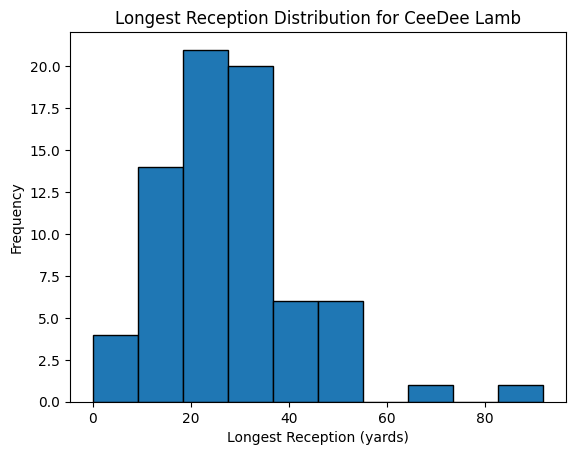

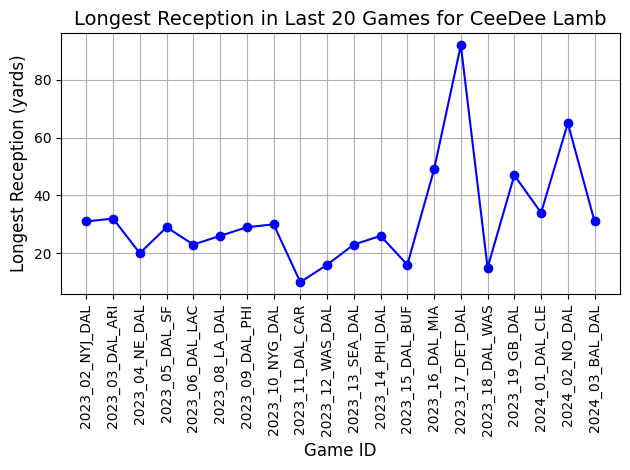

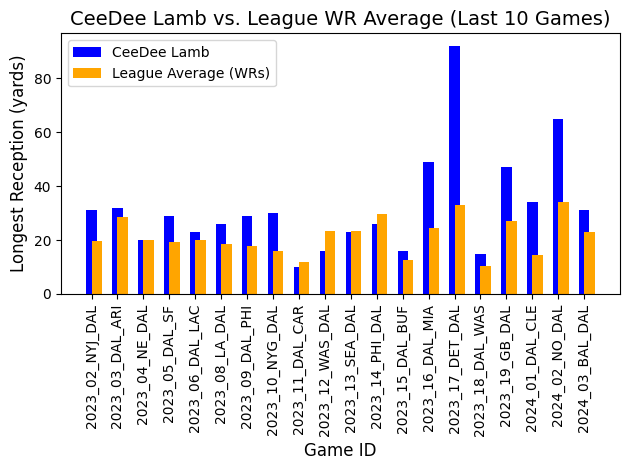

In [34]:
# Longest Reception Analysis

# 1. Distribution of Longest Receptions (Histogram)
def plot_reception_distribution(player_name):
    player_data = data[data['player'] == player_name].dropna(subset=['rec_long'])
    plt.hist(player_data['rec_long'], bins=10, edgecolor='black')
    plt.title(f'Longest Reception Distribution for {player_name}')
    plt.xlabel('Longest Reception (yards)')
    plt.ylabel('Frequency')
    plt.show()
plot_reception_distribution(player_name)

# 2. Longest Reception Over Time (Line Chart)
def plot_last_20_games_reception_trend(player_name):
    player_data = data[data['player'] == player_name].dropna(subset=['rec_long'])
    player_data = player_data.drop_duplicates(subset=['game_id']).sort_values(by='game_id', ascending=True)
    if len(player_data) > 20:
        player_data = player_data[-20:]
    plt.plot(player_data['game_id'], player_data['rec_long'], marker='o', color='blue', label=player_name)
    plt.title(f'Longest Reception in Last 20 Games for {player_name}', fontsize=14)
    plt.xlabel('Game ID', fontsize=12)
    plt.ylabel('Longest Reception (yards)', fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_last_20_games_reception_trend(player_name)

# 3. Double Bar Chart: Last 20 Games vs League Average
def plot_last_10_games_vs_league_avg(player_name):
    player_data = data[(data['player'] == player_name) & (data['rec'] > 0)].dropna(subset=['rec_long'])
    player_last_10 = player_data.drop_duplicates(subset=['game_id']).sort_values(by='game_id').tail(20)
    league_data = data[(data['position'] == 'WR') & (data['rec'] > 0) & (data['rec_long'].notna())]
    league_avg_per_game = league_data.groupby('game_id')['rec_long'].mean().reset_index()
    league_avg_last_10 = league_avg_per_game[league_avg_per_game['game_id'].isin(player_last_10['game_id'])]
    plt.bar(player_last_10['game_id'], player_last_10['rec_long'], width=0.4, label=player_name, align='center', color='blue')
    plt.bar(league_avg_last_10['game_id'], league_avg_last_10['rec_long'], width=0.4, label='League Average (WRs)', align='edge', color='orange')
    plt.title(f'{player_name} vs. League WR Average (Last 10 Games)', fontsize=14)
    plt.xlabel('Game ID', fontsize=12)
    plt.ylabel('Longest Reception (yards)', fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_last_10_games_vs_league_avg(player_name)


### Tight Ends <a id="tight-ends"></a>

---

## RANDOM <a id="random"></a>